# LAB 2.1 - CNS (Hebbian learning)

Import of libraries and fixing of random seed.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from typing import Callable

np.random.seed(10)

Function able to show the scatter plot with data and vectors related to first and second principal eigenvectors of data and weights vector.

In [2]:
def data_pc_w_plot(ax, data: np.array, first_pc: np.array = None, second_pc: np.array = None,
                   W: np.array = None) -> None:
    """
    Function able to show the scatter plot with data and vectors related to first and second principal eigenvectors of data and weights vector.

    ax: Matplotlib axis where write the plot.
    data: Dataset shown in scatter plot.
    first_pc: First principal eigenvector.
    second_pc: Second principal eigenvector.
    W: Weights vector.
    """
    ax.scatter(*data)
    if first_pc is not None:
        ax.quiver(*first_pc, color='y', label='First principal component of dataset', width=0.007)
    if second_pc is not None:
        ax.quiver(*second_pc, color='g', label='Second principal component of dataset', width=0.007)
    if W is not None:
        ax.quiver(*W, color='r', label='Weights vector', width=0.005)
    if first_pc is not None or second_pc is not None or W is not None:
        ax.legend()

Dataset loading and plot in a scatter plot.

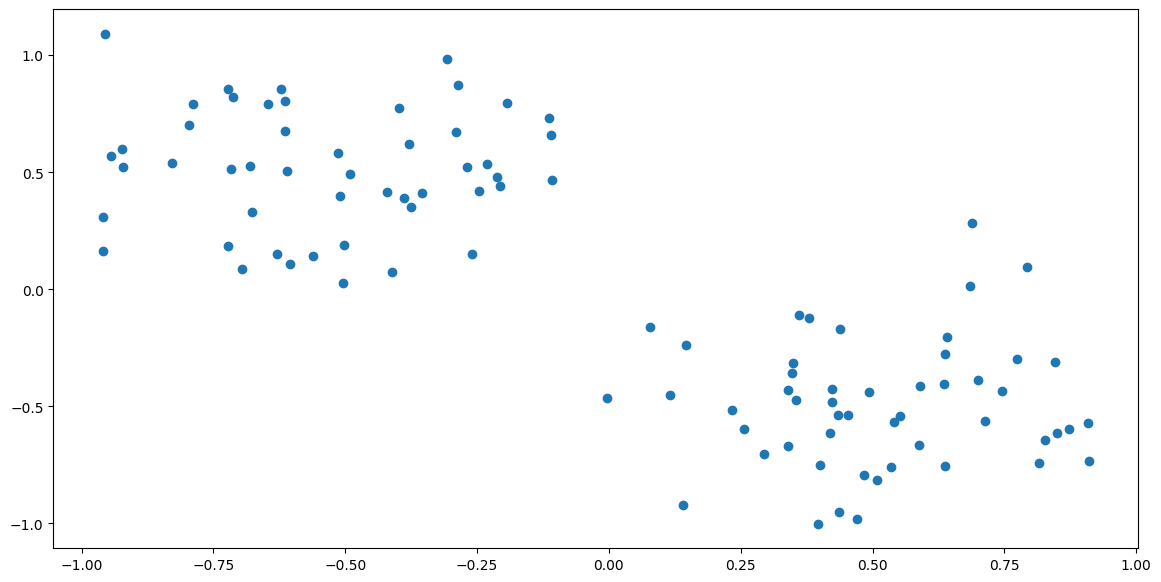

In [3]:
data = pd.read_csv('lab2_1_data.csv', header=None).to_numpy()

plt.figure(figsize=(14, 7))
data_pc_w_plot(plt, data=data)
plt.show()

Principal Component Analysis of dataset from the correlation matrix and visualization of first and second principal component (eigenvector related to the highest eigenvalues).

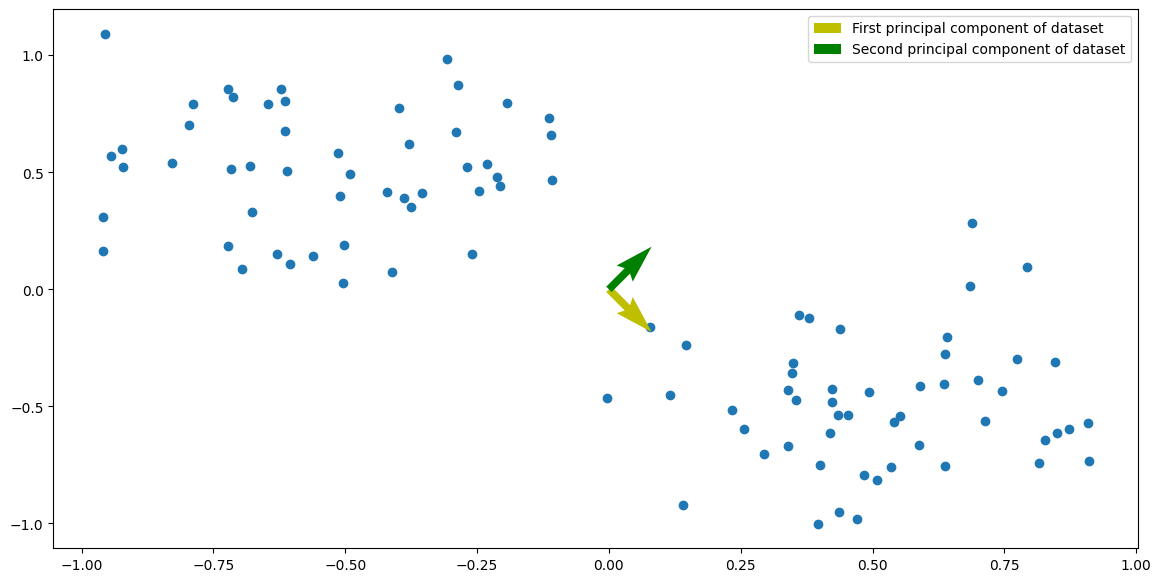

In [4]:
def extract_principal_components(dataset: np.array) -> tuple[np.array, np.array]:
    """
    Function able to extract the two principal eigenvectors.

    dataset: Dataset where do the Principal Component Analysis.

    returns:
        tuple[np.array, np.array]: Tuple of first and second principal eigenvectors.
    """
    C = np.corrcoef(dataset)
    eig_vals, eig_vects = np.linalg.eig(C)
    eig_vals = np.argsort(eig_vals)[::-1]
    return eig_vects.T[eig_vals[0]], eig_vects.T[eig_vals[1]]


first_pc, second_pc = extract_principal_components(data)
plt.figure(figsize=(14, 7))
data_pc_w_plot(plt, data=data, first_pc=first_pc, second_pc=second_pc)
plt.show()

Weights vector (W) initialization and visualization in data plot.

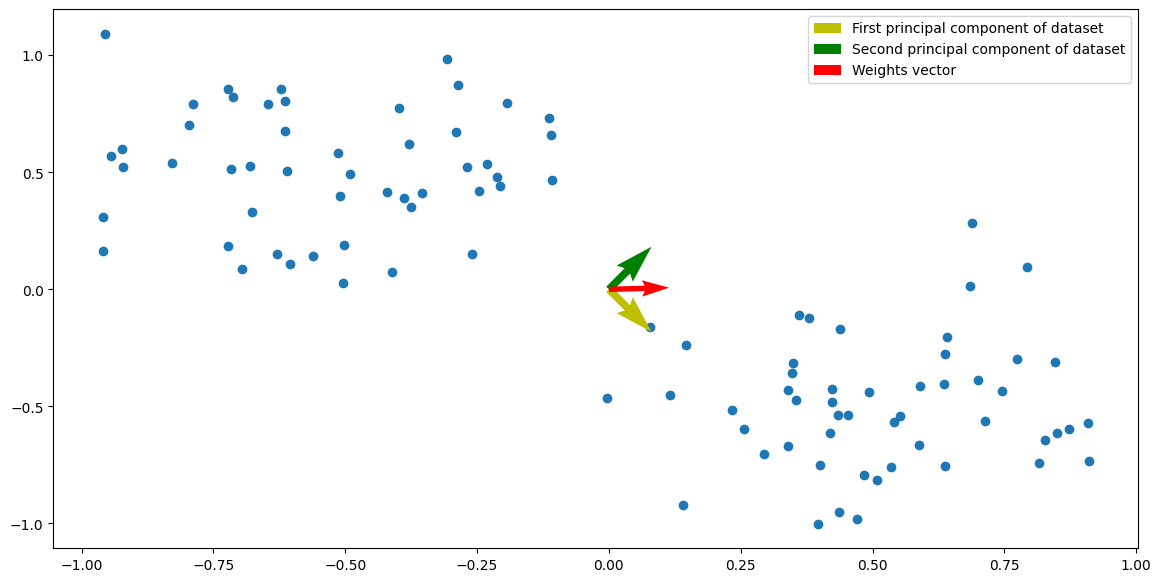

In [5]:
W = np.random.rand(data.shape[0])

plt.figure(figsize=(14, 7))
data_pc_w_plot(plt, data=data, first_pc=first_pc, second_pc=second_pc, W=W)
plt.show()

Function able to plot the analysis on weights vector. This function is able to show 4 plots:
1. Scatter plot of data with first and second principal eigenvectors and weights vector.
2. Change of weights norm over time.
3. Change of first weights vector component (x) over time.
4. Change of second weights vector component (y) over time.

In [6]:
def plot_analysis(weights_evolution: np.array, title: str, dataset: np.array = data, save: bool = True) -> None:
    """
    Plot able to plot the entire analysis on list of evolution of weights vectors.

    weights_evolution: List of weights vectors for each step of training.
    title: Title of plot.
    save: Flag to save the plot as a file.
    """
    plt.figure(figsize=(20, 20))
    plt.suptitle(title)

    ax = plt.subplot(3, 2, 1)
    ax.set_title('Data, first component of PCA and weights vector')
    f_pc, s_pc = extract_principal_components(dataset)
    data_pc_w_plot(ax, data=dataset, first_pc=f_pc, second_pc=s_pc, W=weights_evolution[-1])

    x = list(range(len(weights_evolution)))
    ax = plt.subplot(3, 2, 2)
    ax.set_title('Weights norm')
    ax.grid(True)
    ax.plot(x, [np.linalg.norm(w) for w in weights_evolution])
    ax.set_xlabel('Learning steps')
    ax.set_ylabel('Weights norm')

    ax = plt.subplot(3, 2, 3)
    ax.set_title('First component of weights vector - x axis')
    ax.grid(True)
    ax.plot(x, [w[0] for w in weights_evolution])
    ax.set_xlabel('Learning steps')
    ax.set_ylabel('Weights first component')

    ax = plt.subplot(3, 2, 4)
    ax.set_title('Second component of weights vector - y axis')
    ax.grid(True)
    ax.plot(x, [w[1] for w in weights_evolution])
    ax.set_xlabel('Learning steps')
    ax.set_ylabel('Weights second component')

    if save:
        plt.savefig(f'hebbian_learning_assets/plots/{title}.png')

Function able to train the weights vector given a learning rule and collect the list of weights vector evolution over time.

In [7]:
def train(
        dataset: np.array,
        w: np.array,
        learning_rule: Callable,
        epochs: int = 500, lr: float = 1e-3,
        weights_threshold: float = 1e-4,
        filename: str = None
) -> np.array:
    """
    dataset: Dataset.
    w: Weights vector.
    learning_rule: Learning rule callback.
    Epochs: Maximum number of epoch.
    lr: Learning reate.
    weights_threshold: Threshold to stop training if the norm of difference between new and old weights is under it.
    filename: Name of file where save the matrix of weights evolution.

    returns:
        np.array: Weights evolution.
    """
    weights_evolution = [w]
    w_previous_epoch = None
    for epoch in range(epochs):
        dataset = np.random.permutation(dataset.T).T
        for u in data.T:
            v = w.T @ u
            delta_w = learning_rule(v, u, w)
            w = w + lr * delta_w
            weights_evolution.append(w)
        if w_previous_epoch is not None and np.linalg.norm(w_previous_epoch - w) < weights_threshold:
            break
        else:
            w_previous_epoch = w
    weights_evolution = np.array(weights_evolution)
    if filename is not None:
        np.save(f'hebbian_learning_assets/output_data/{filename} - weights evolution', weights_evolution)
    return weights_evolution

## Assignment 1 - Basic Hebbian learning

Analysis with basic Hebbian rule. We can see that weights vector is parallel to the first principal eigenvector as expected. The other plots shows the unstable nature of this learning rule because first component, second component and norm of weights vector grow without reach a bound.

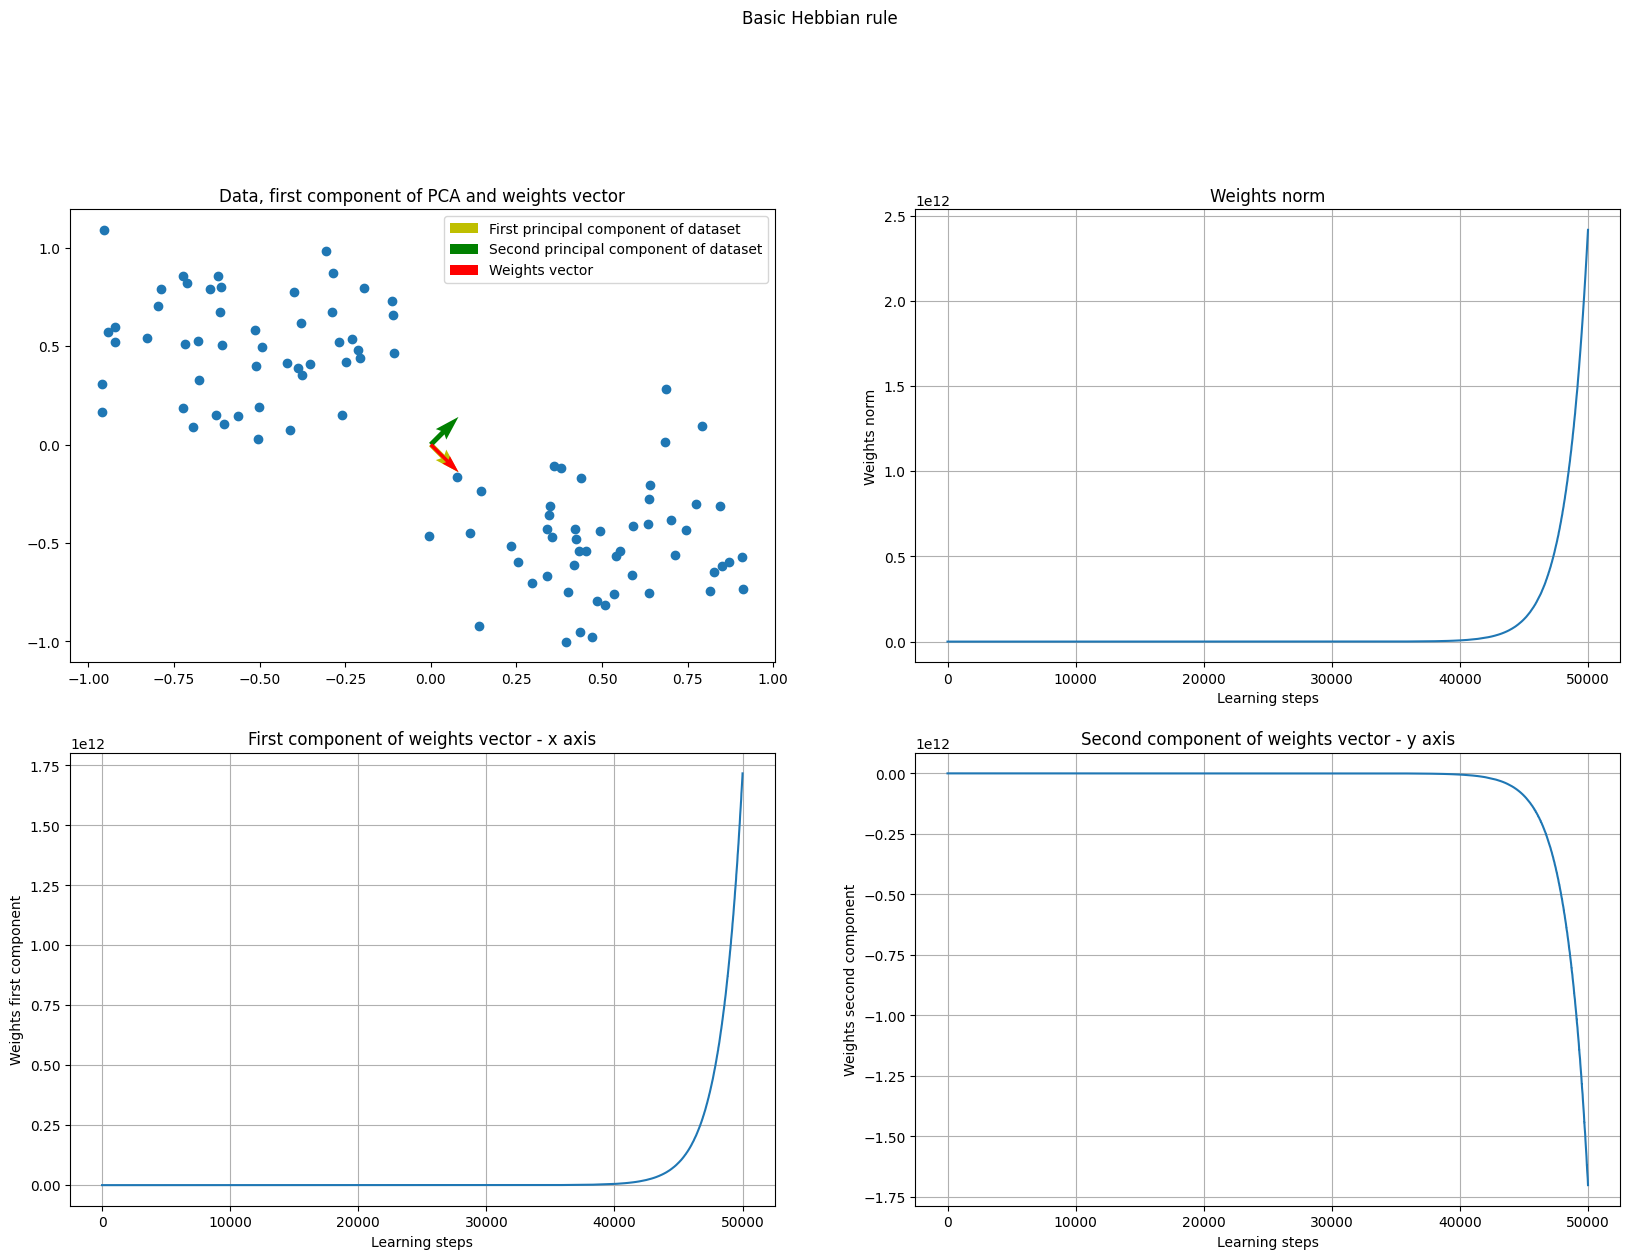

In [8]:
title = 'Basic Hebbian rule'
basic_hebbian_rule = lambda v, u, w: v * u

weights_over_time = train(data, W, learning_rule=basic_hebbian_rule, filename=title)
plot_analysis(weights_over_time, title=title)

## Assignment 2 - Oja rule

Analysis with Oja rule. We can see that weights vector is parallel to the first principal eigenvector as expected. The other plots shows the stable nature of this learning rule because first component, second component and norm of weights vector reach a bound and stabilize there. Changing the value of alpha we can see that using a higher value the stabilization is faster and reach a stabilization point closer to zero.

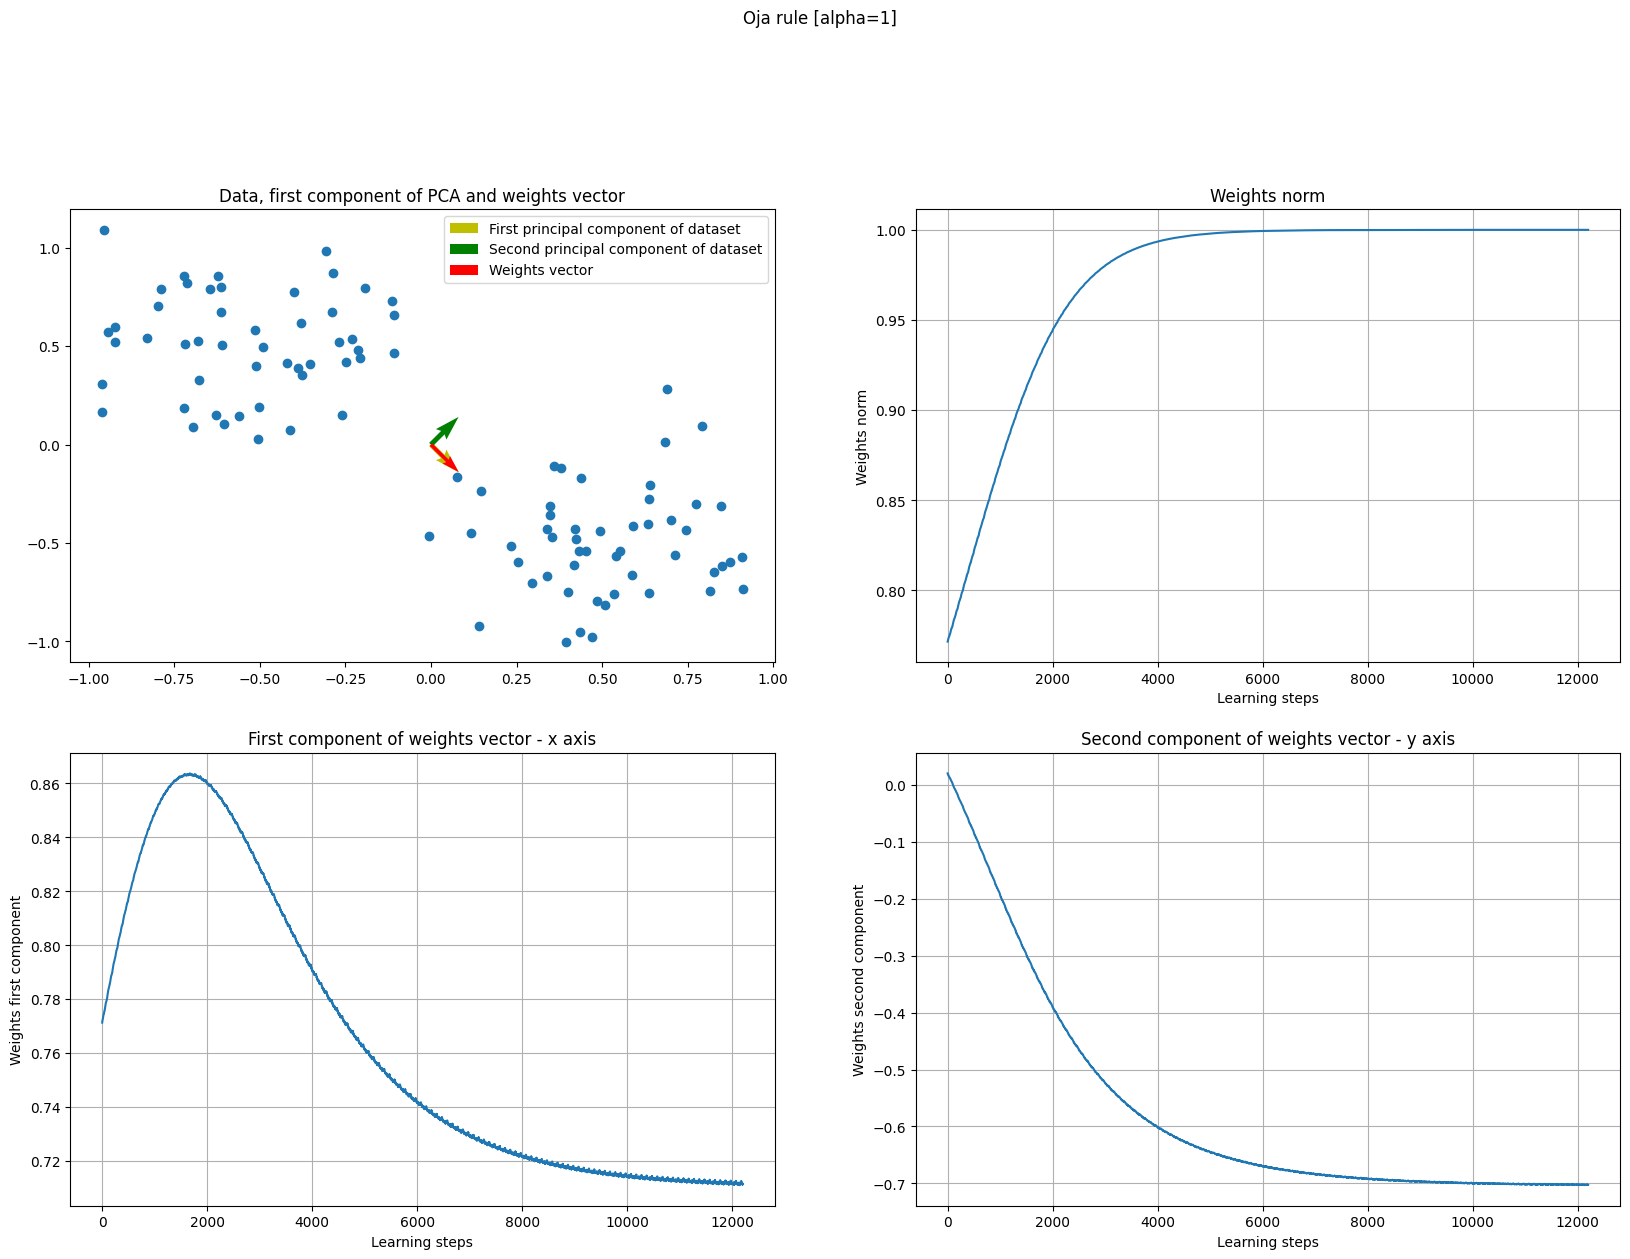

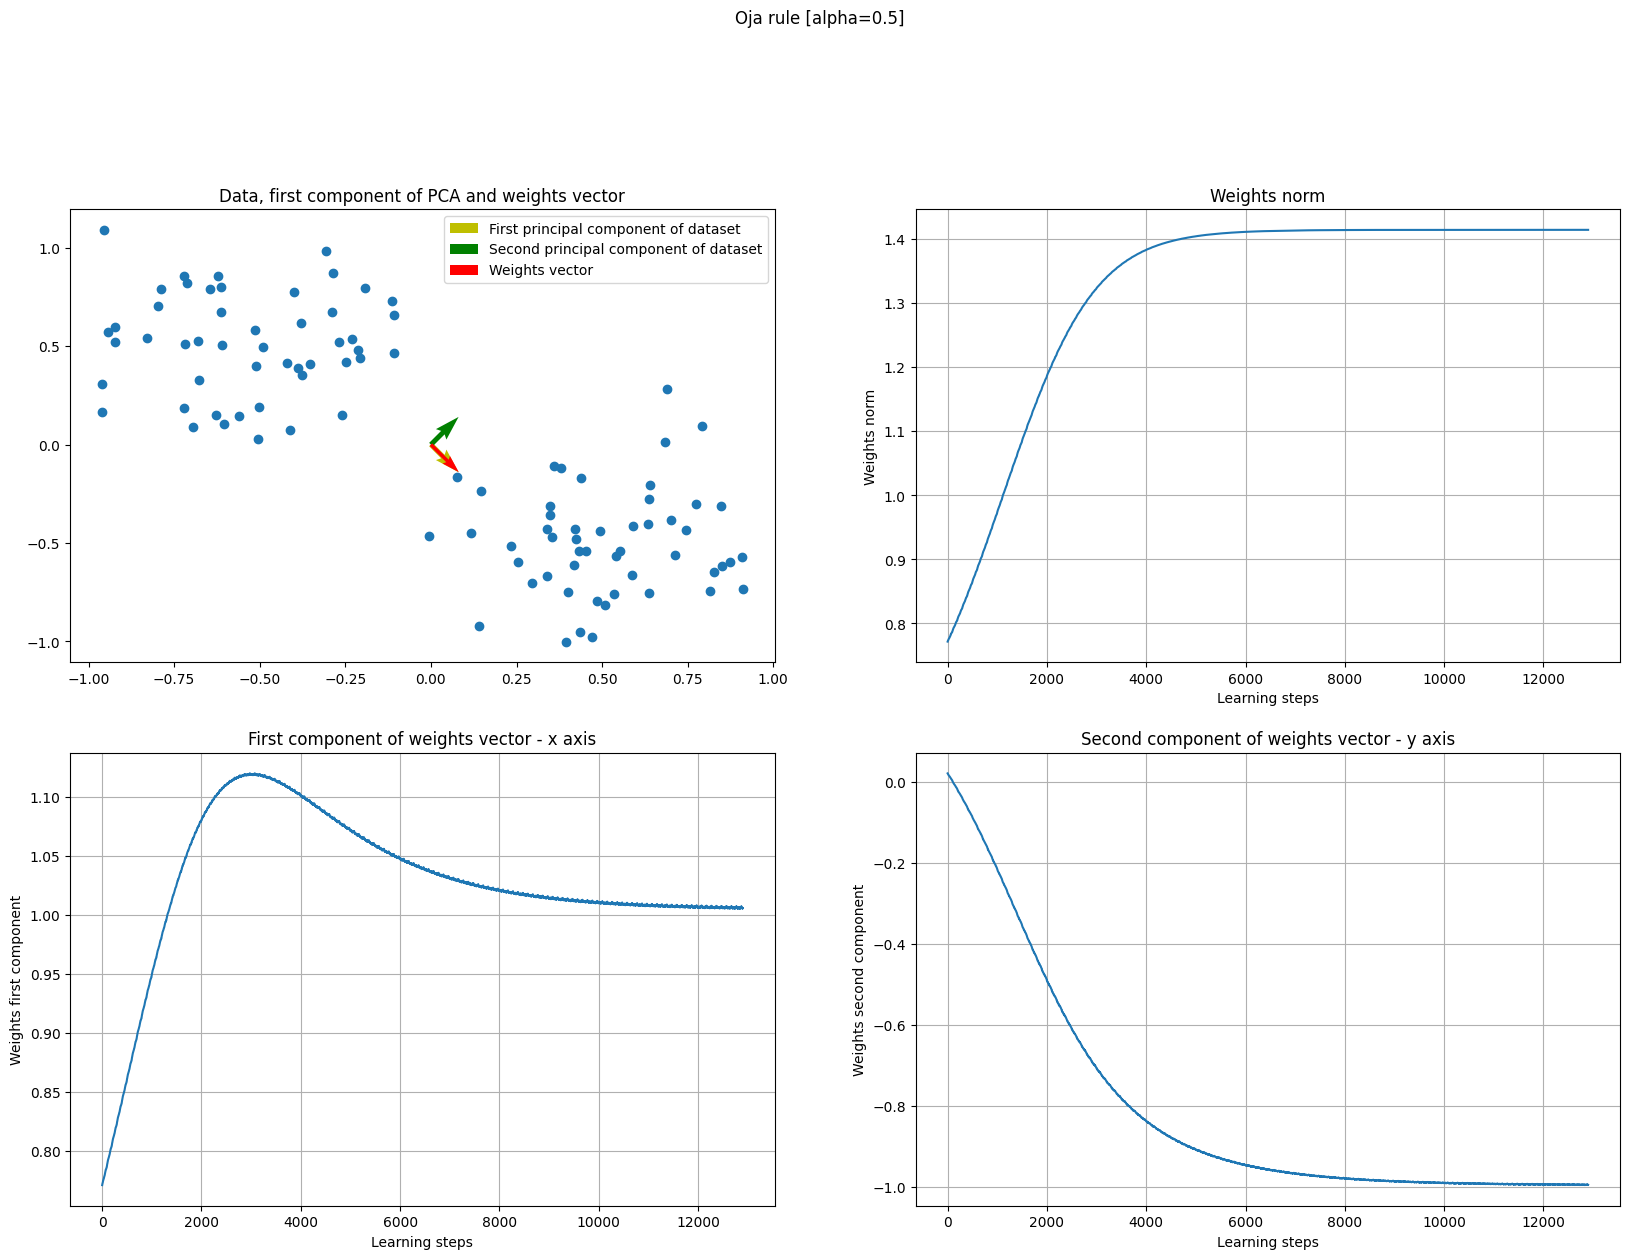

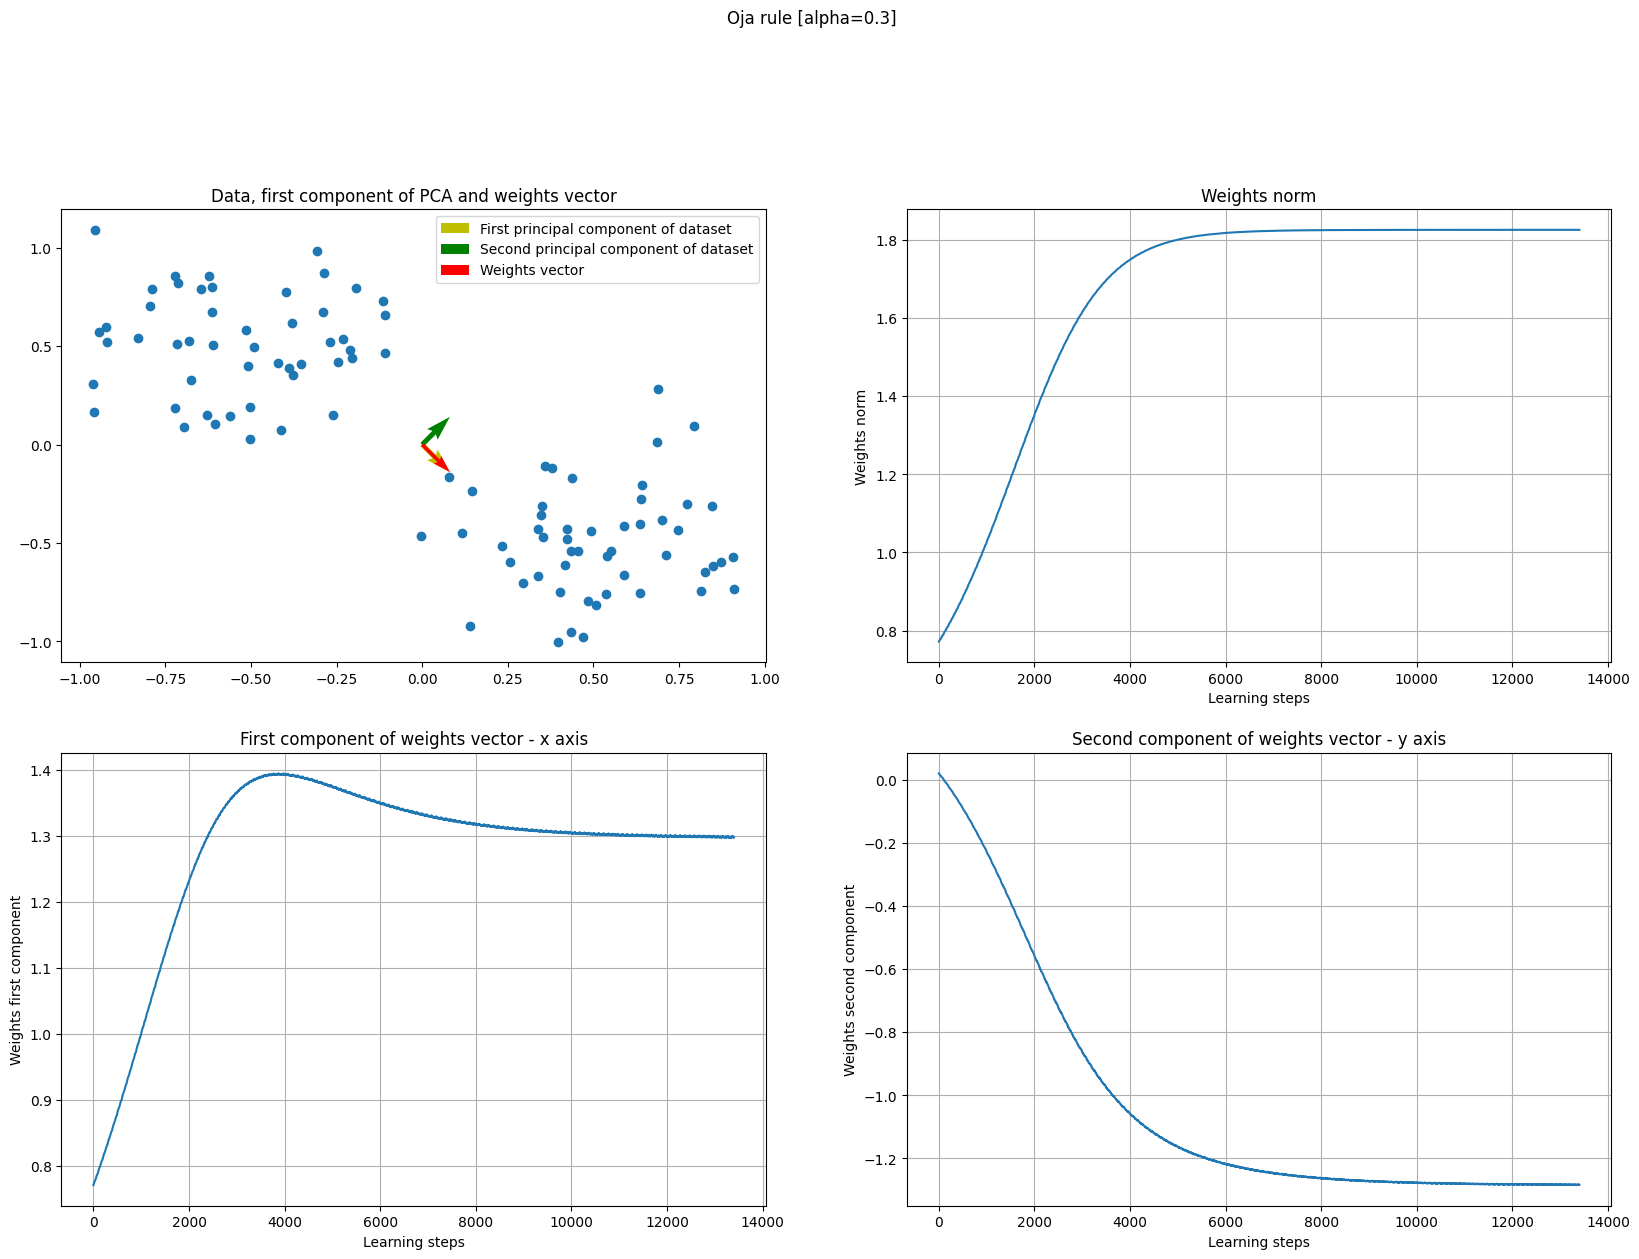

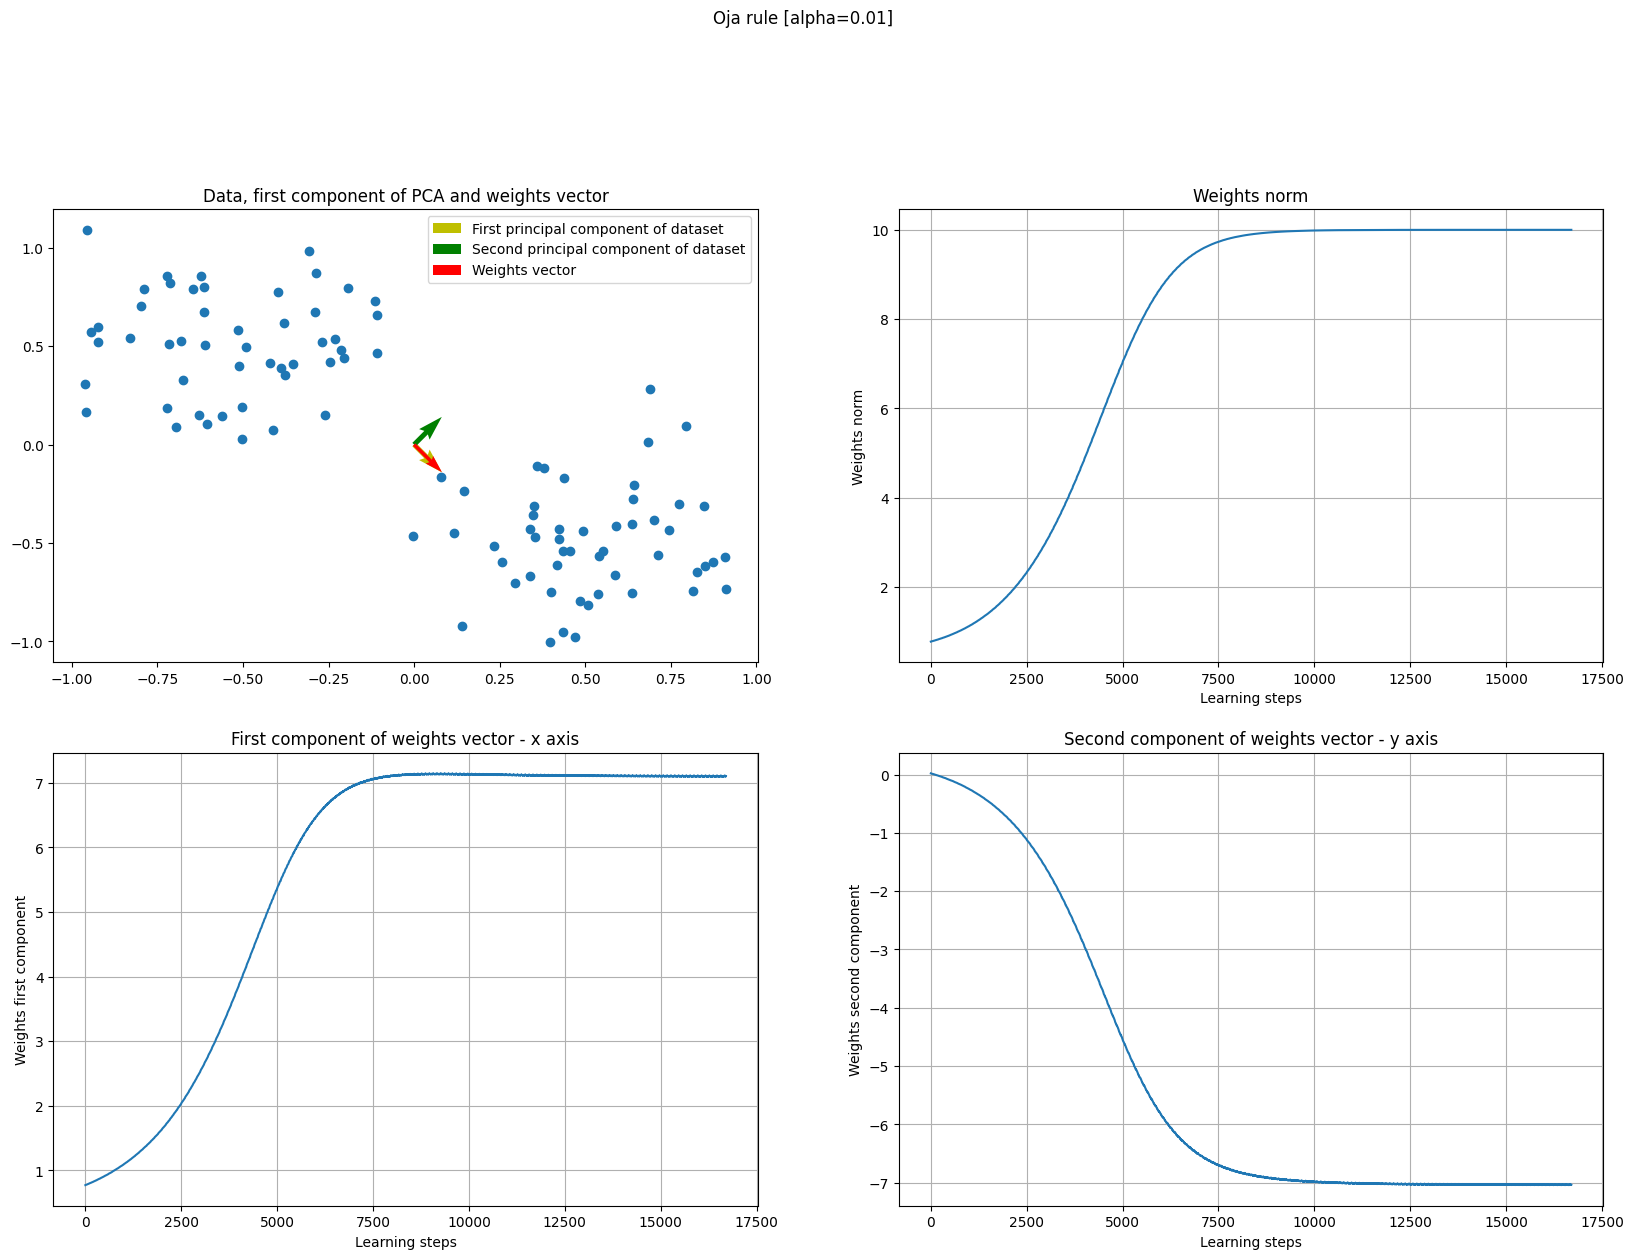

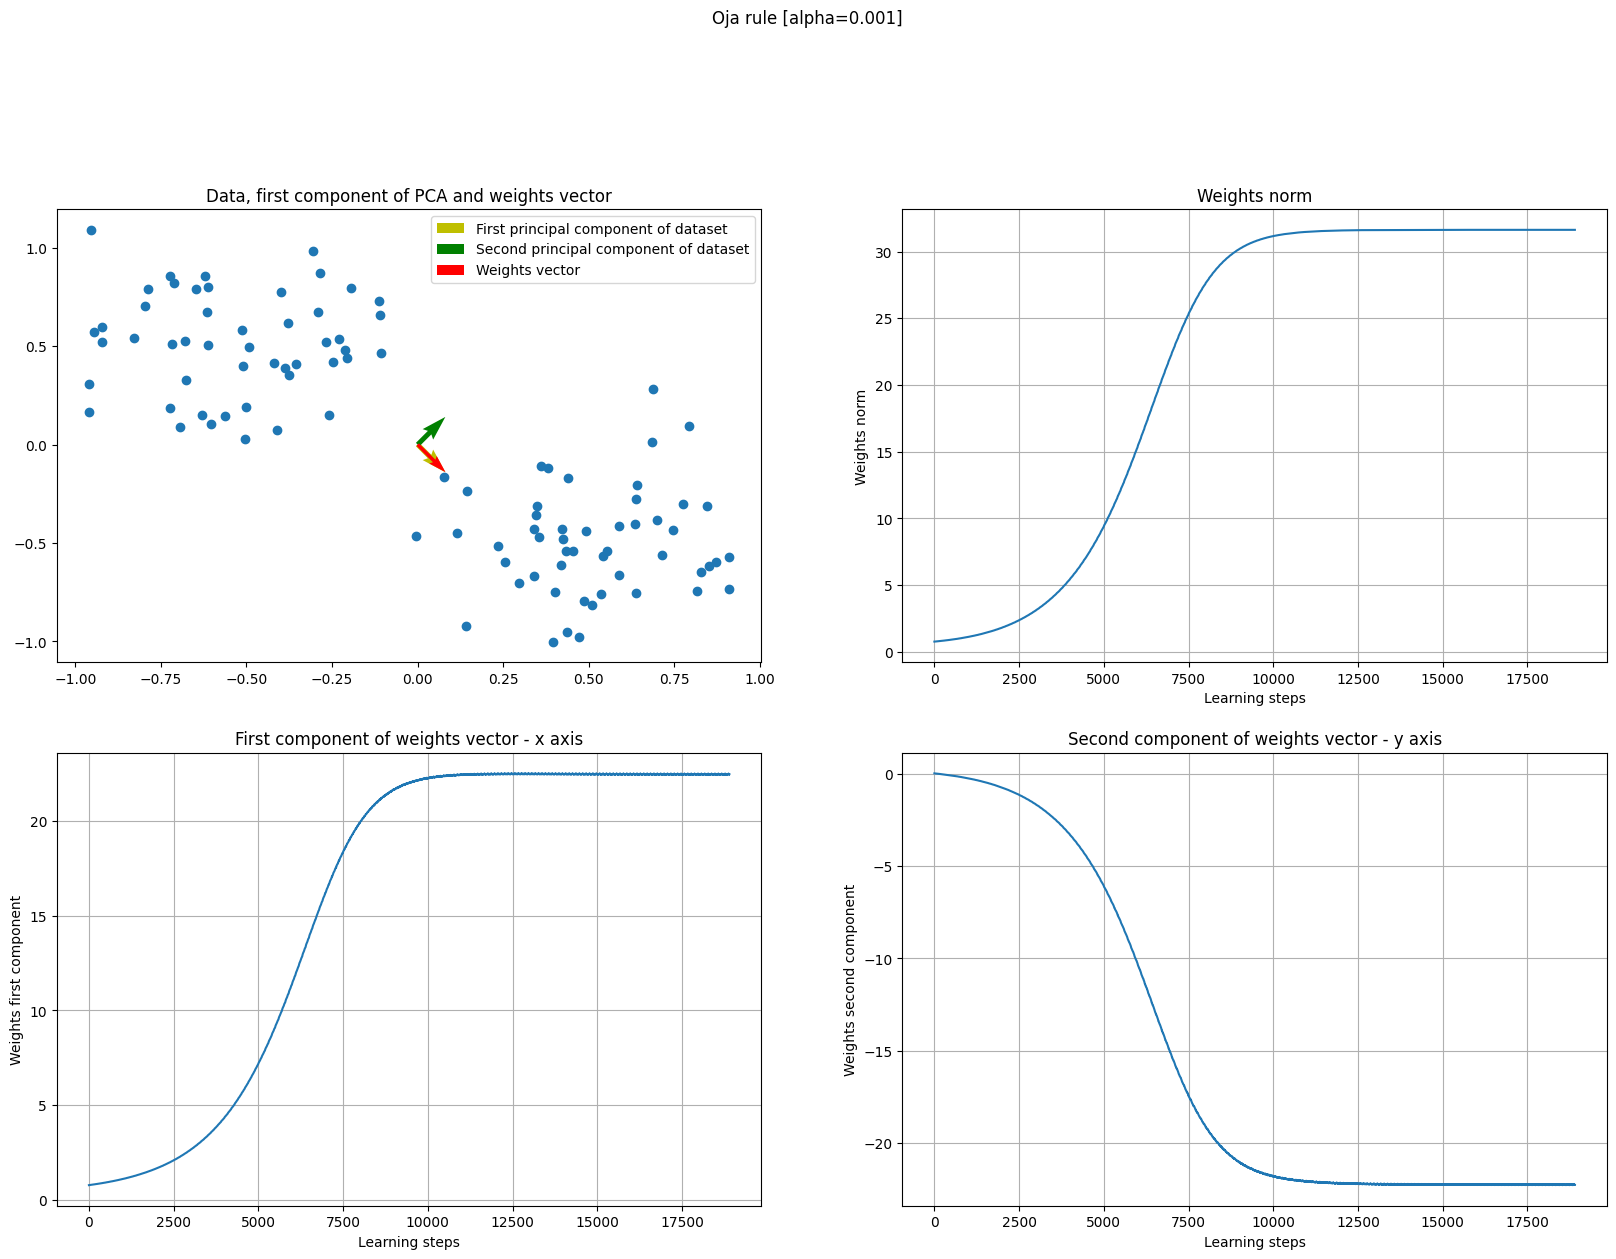

In [9]:
for alpha in [1, 0.5, 0.3, 0.01, 0.001]:
    title = f'Oja rule [alpha={alpha}]'
    oja_rule = lambda v, u, w: v * u - alpha * v ** 2 * w
    weights_over_time = train(data, W, learning_rule=oja_rule, filename=title)
    plot_analysis(weights_over_time, title=title)

## Assignment 3 - Subtractive normalization

Analysis with subtractive normalization rule. We can see that weights vector is parallel to the first principal eigenvector as expected. In the other plots the values on first component, second component and norm of weights vector grow in an unbounded way. This rule is able to control the sum of weights as we can see in the last plot.

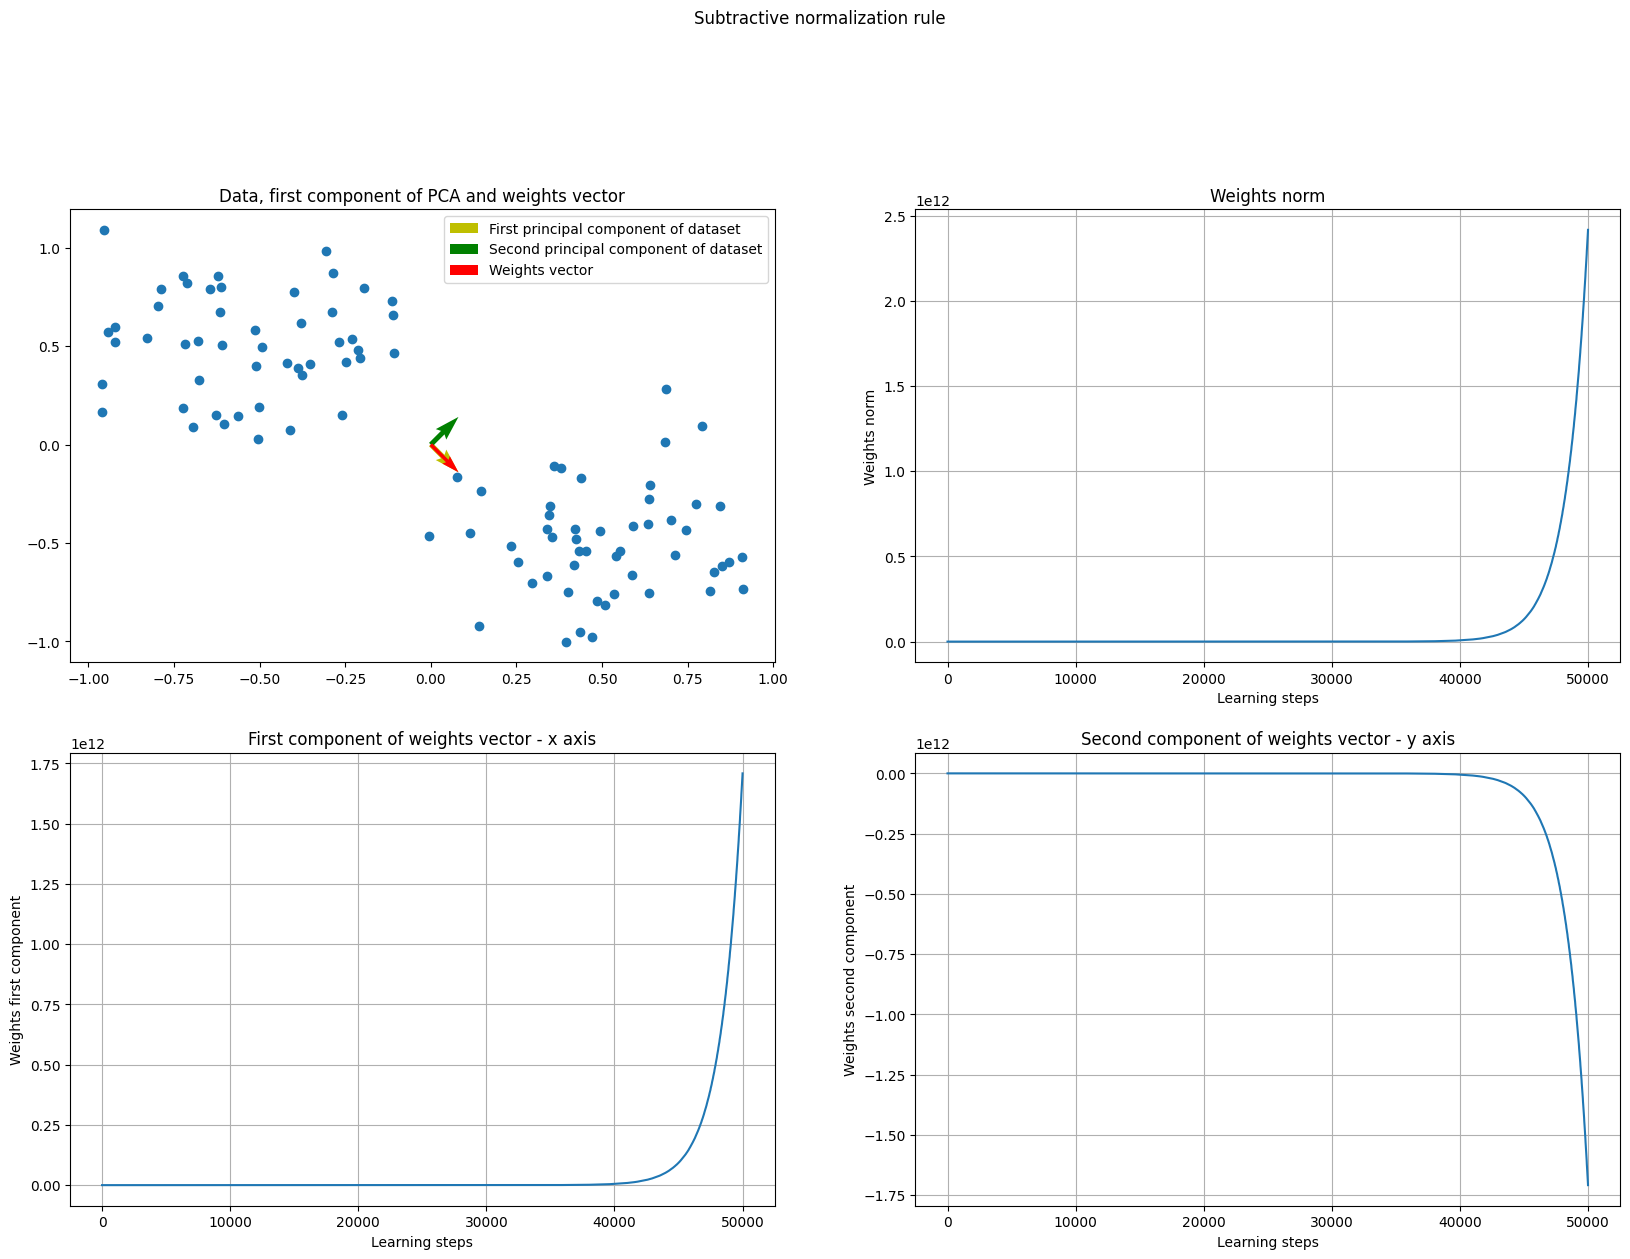

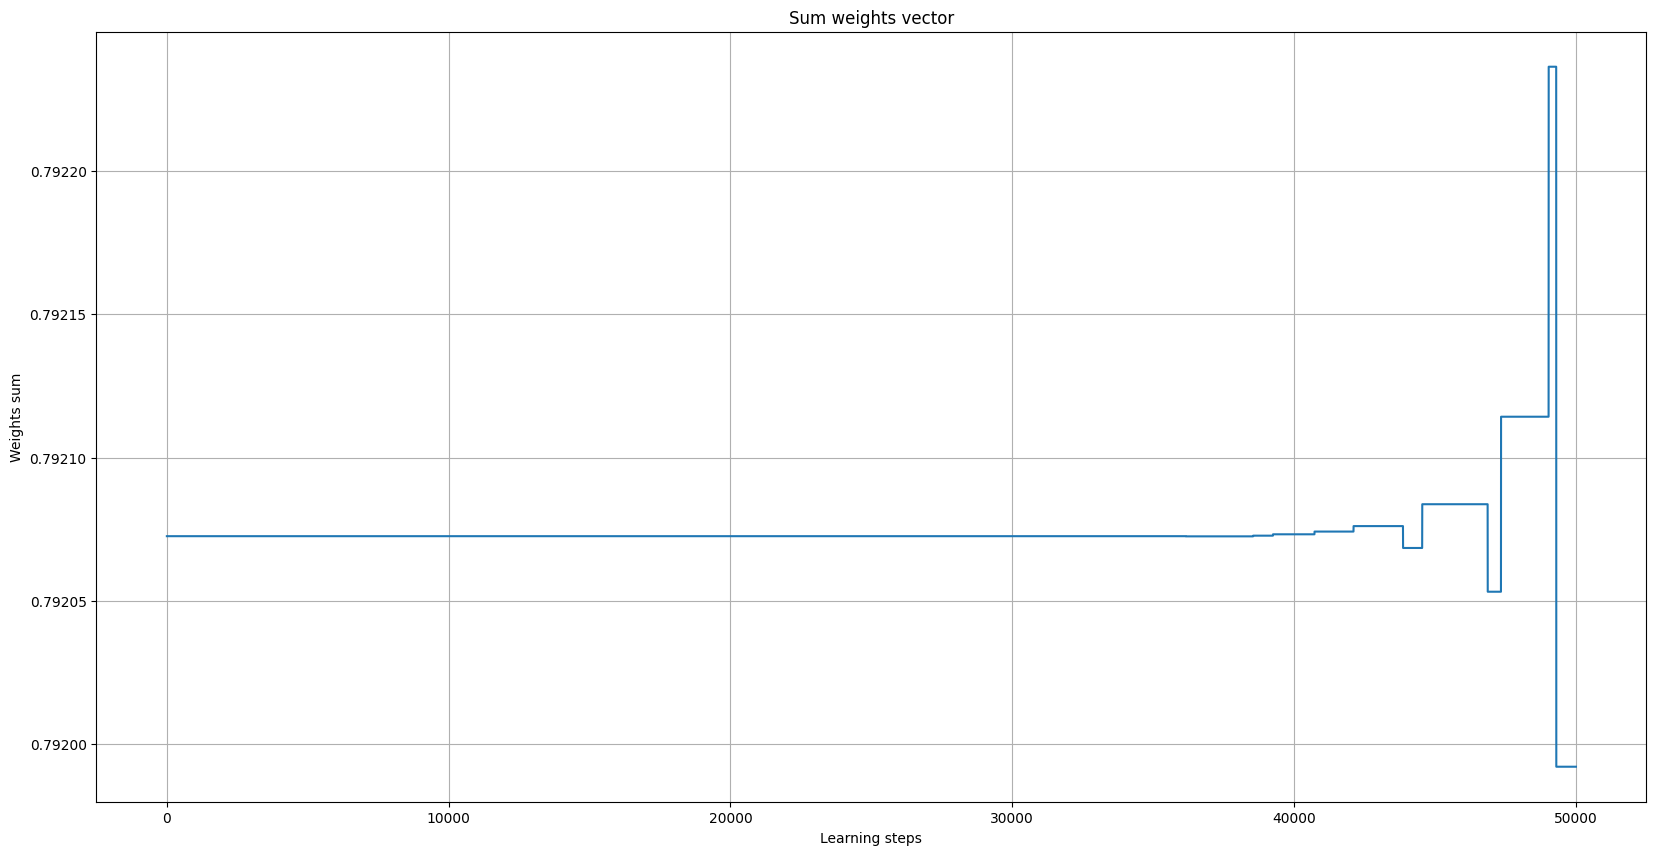

In [10]:
title = 'Subtractive normalization rule'
n = np.ones(data.shape[0])
subtractive_normalization = lambda v, u, w: v * u - ((v * (n.T @ u) * n) / 2)

weights_over_time = train(data, W, learning_rule=subtractive_normalization, filename=title)
plot_analysis(weights_over_time, title=title)

plt.figure(figsize=(20, 10))
plt.title('Sum weights vector')
plt.grid(True)
plt.plot(list(range(weights_over_time.shape[0])), [w.sum() for w in weights_over_time])
plt.xlabel('Learning steps')
plt.ylabel('Weights sum')

plt.show()

## Bonus track assignment 1 - BCM rule

We create a class to handle theta parameter of BCM rule. In this way in the constructor we can pass parameters and a flag to make the BCM rule stable or not (updating or not each time the theta parameter).

In [11]:
class BCMRule:
    """
    Class able to store BCM rule parameter as theta and provide a way to call it as a function to pass this as a learning rule to the train function.
    """

    def __init__(self, initial_theta: float = 0.01, theta_lr: float = 0.1, stable: bool = True):
        """
        BCM rule class constructor.

        initial_theta: Initial value of theta.
        theta_lr: Theta learning rate. This is used only when BCM is set to be stable.
        stable: Parameter to stabilize or not the BCM rule.
        """
        self.theta = initial_theta
        self.theta_lr = theta_lr
        self.stable = stable

    def __call__(self, v: float, u: np.array, w: np.array) -> np.array:
        """
        Function to make this class callable as a function.

        v: Postsynaptic firing rate value.
        u: Presynaptic firing rate vector.
        w: Weights vector.

        returns:
            np.array: Delta of weights passed to the train function to update the weights vector.
        """
        if self.stable:
            self.theta = self.theta + self.theta_lr * (v ** 2 - self.theta)
        return v * u * (v - self.theta)

Function able to pack the bcm rule simulation passing a list of configurations in input.

In [12]:
def simulate_bcm_rule(configs: list[tuple[BCMRule, np.array, int, float]]) -> None:
    """
    Function able to simulate the BCM rule with a list of configurations.

    configs: List of configurations. Each configuration is a tuple of BCM rule, initial weights vector, number of max epochs and learning rate
    """
    for bcm_rule, initial_W, epochs, lr in configs:
        title = f'BCM rule - initial_W={initial_W}, stable={bcm_rule.stable}, initial_theta={bcm_rule.theta}'
        if bcm_rule.stable:
            title += f', theta_lr={bcm_rule.theta_lr}'
        wot = train(data, initial_W, learning_rule=bcm_rule, filename=title, epochs=epochs, lr=lr)
        plot_analysis(wot, title=title)

Two simulations of BCM rule unstable.
1. In the first example we can see that in the scatter plot of data the weights vector follows the second principal eigenvector while the evolution of weights seem to be bounded in first component, second component and norm of weights. These weights evolutions seem to follow a zig-zag behavior.
2. In the second example theta seems to be not right to bound the grow of weights vector.

/var/folders/mk/7s16j9k90j15d4m_gz0c5txc0000gn/T/ipykernel_18767/565437318.py:31: RuntimeWarning: overflow encountered in multiply
  return v * u * (v - self.theta)
/var/folders/mk/7s16j9k90j15d4m_gz0c5txc0000gn/T/ipykernel_18767/225604979.py:28: RuntimeWarning: invalid value encountered in add
  w = w + lr * delta_w
/Users/geremiapompei/Library/CloudStorage/OneDrive-UniversityofPisa/UNIPI/2_anno_2022_2023/2_semestre/computational neuroscience/assignments/cns_lab/venv/lib/python3.10/site-packages/matplotlib/quiver.py:628: RuntimeWarning: Mean of empty slice.
  amean = a[~self.Umask].mean()
/Users/geremiapompei/Library/CloudStorage/OneDrive-UniversityofPisa/UNIPI/2_anno_2022_2023/2_semestre/computational neuroscience/assignments/cns_lab/venv/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


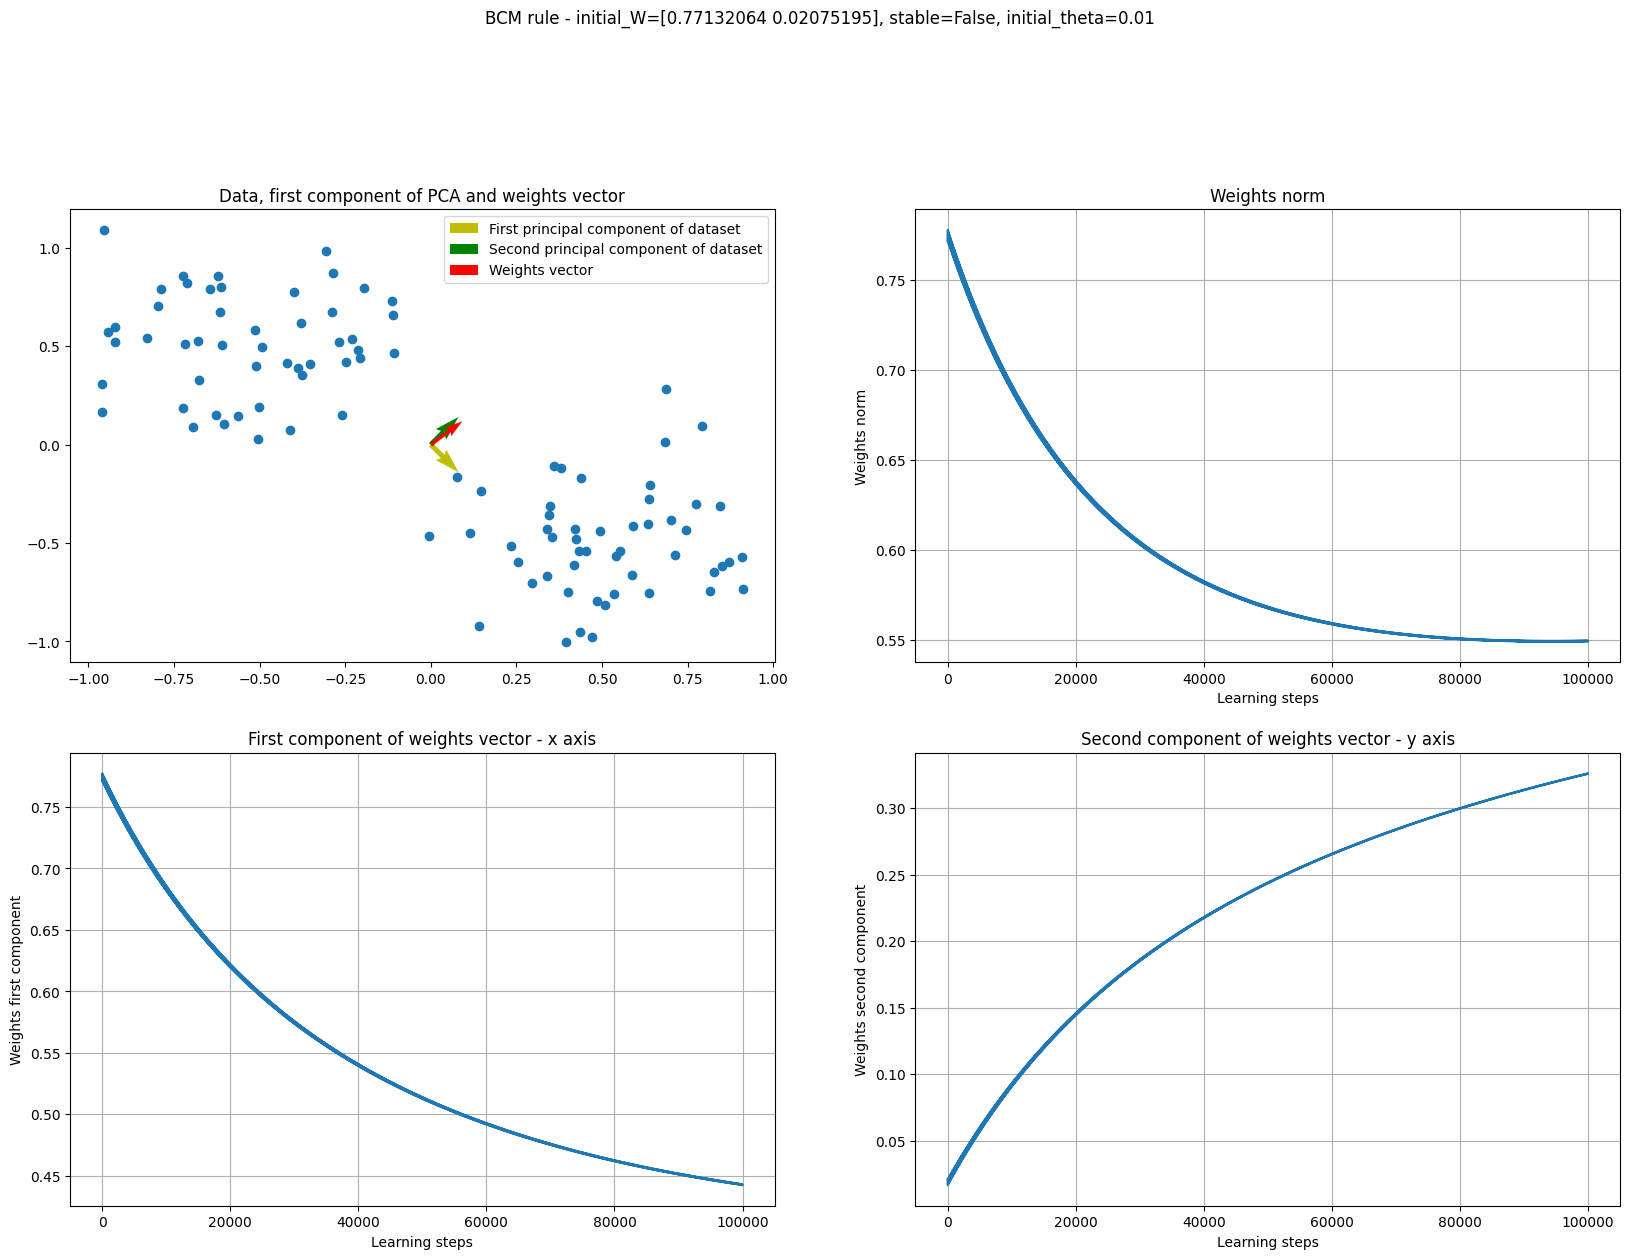

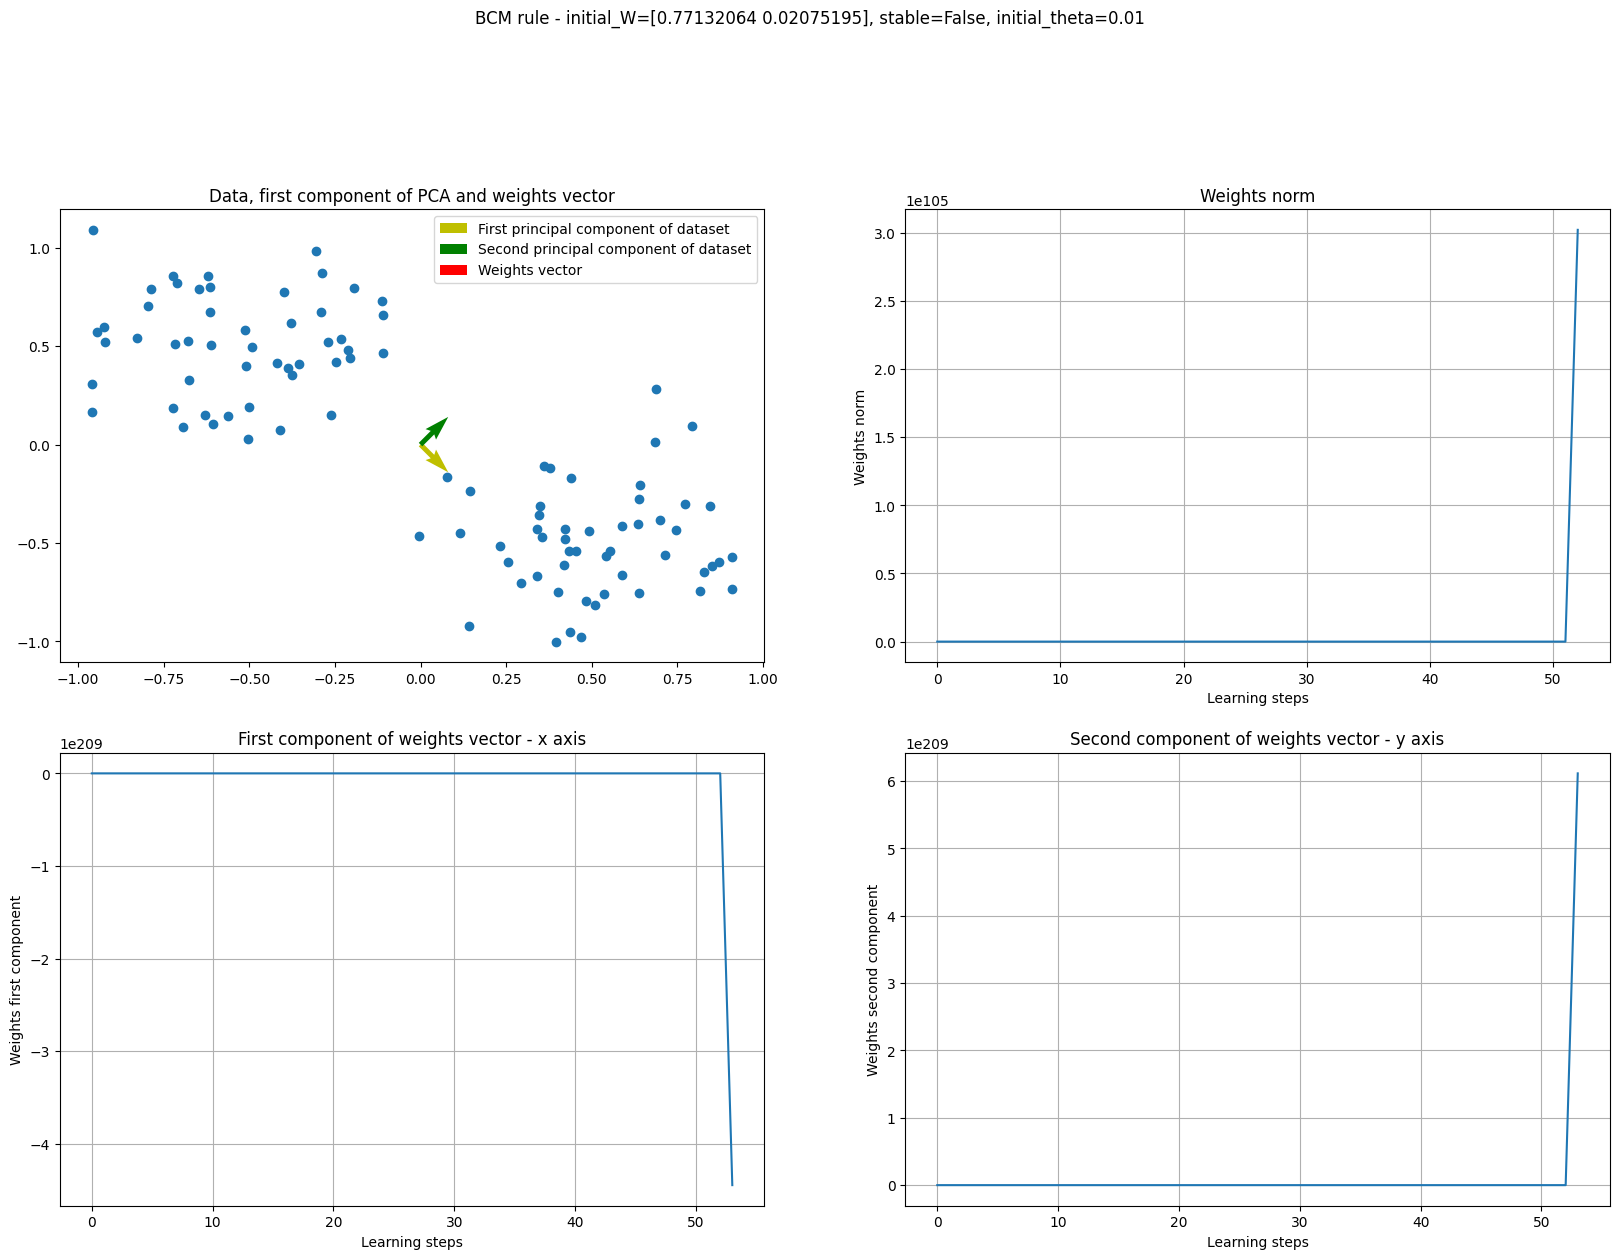

In [13]:
simulate_bcm_rule([
    (BCMRule(initial_theta=0.01, stable=False), W, 1000, 0.001),
    (BCMRule(initial_theta=0.01, stable=False), W, 1000, 0.1),
])

Here we have 2 simulations of BCM rule with different weights initialization.
1. First example is with an initial weights vector parallel to the first principal component. After training it tends to be aligned to the second prinipal component.
2. Either in the second example with the usual initial weights vector we have an alignment to the second principal component.

These examples are stabilized and we can look this in the other plots related to the first component, the second component and the norm of weights because they seem to converge to a fixed value.

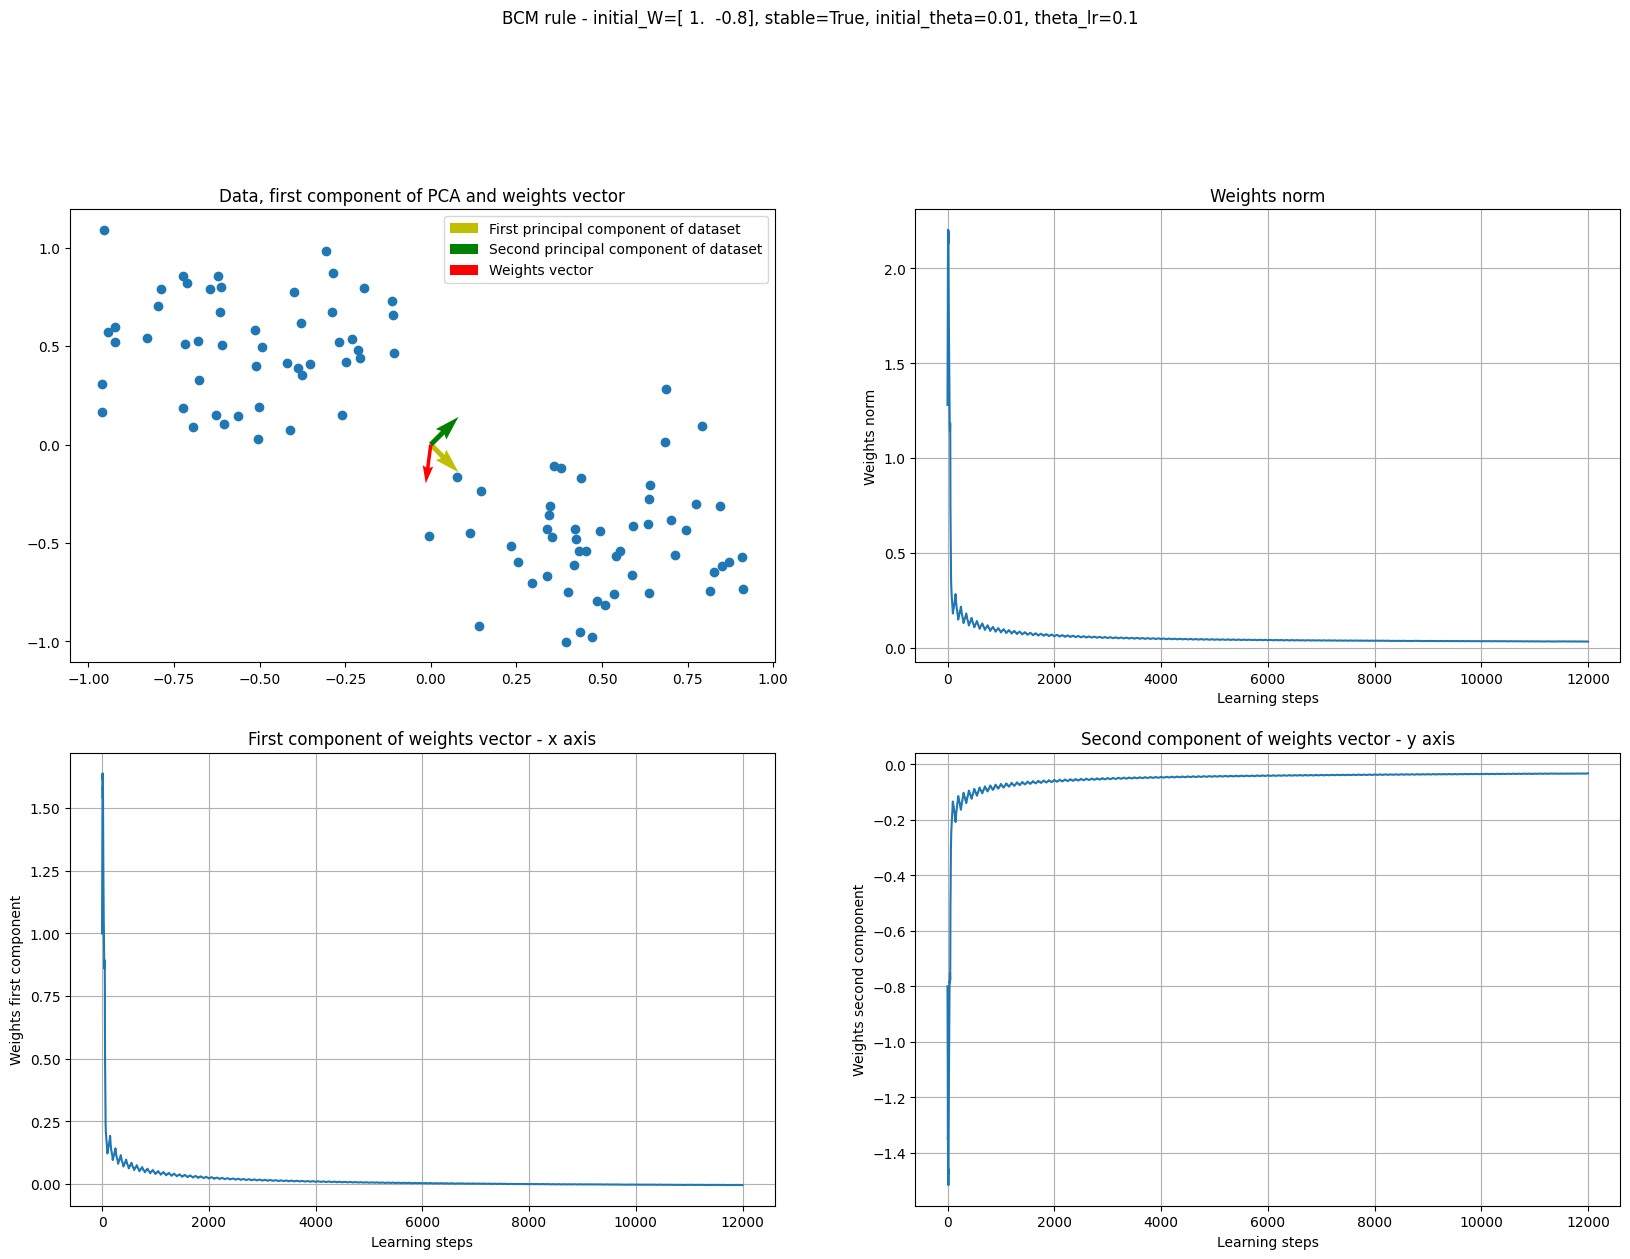

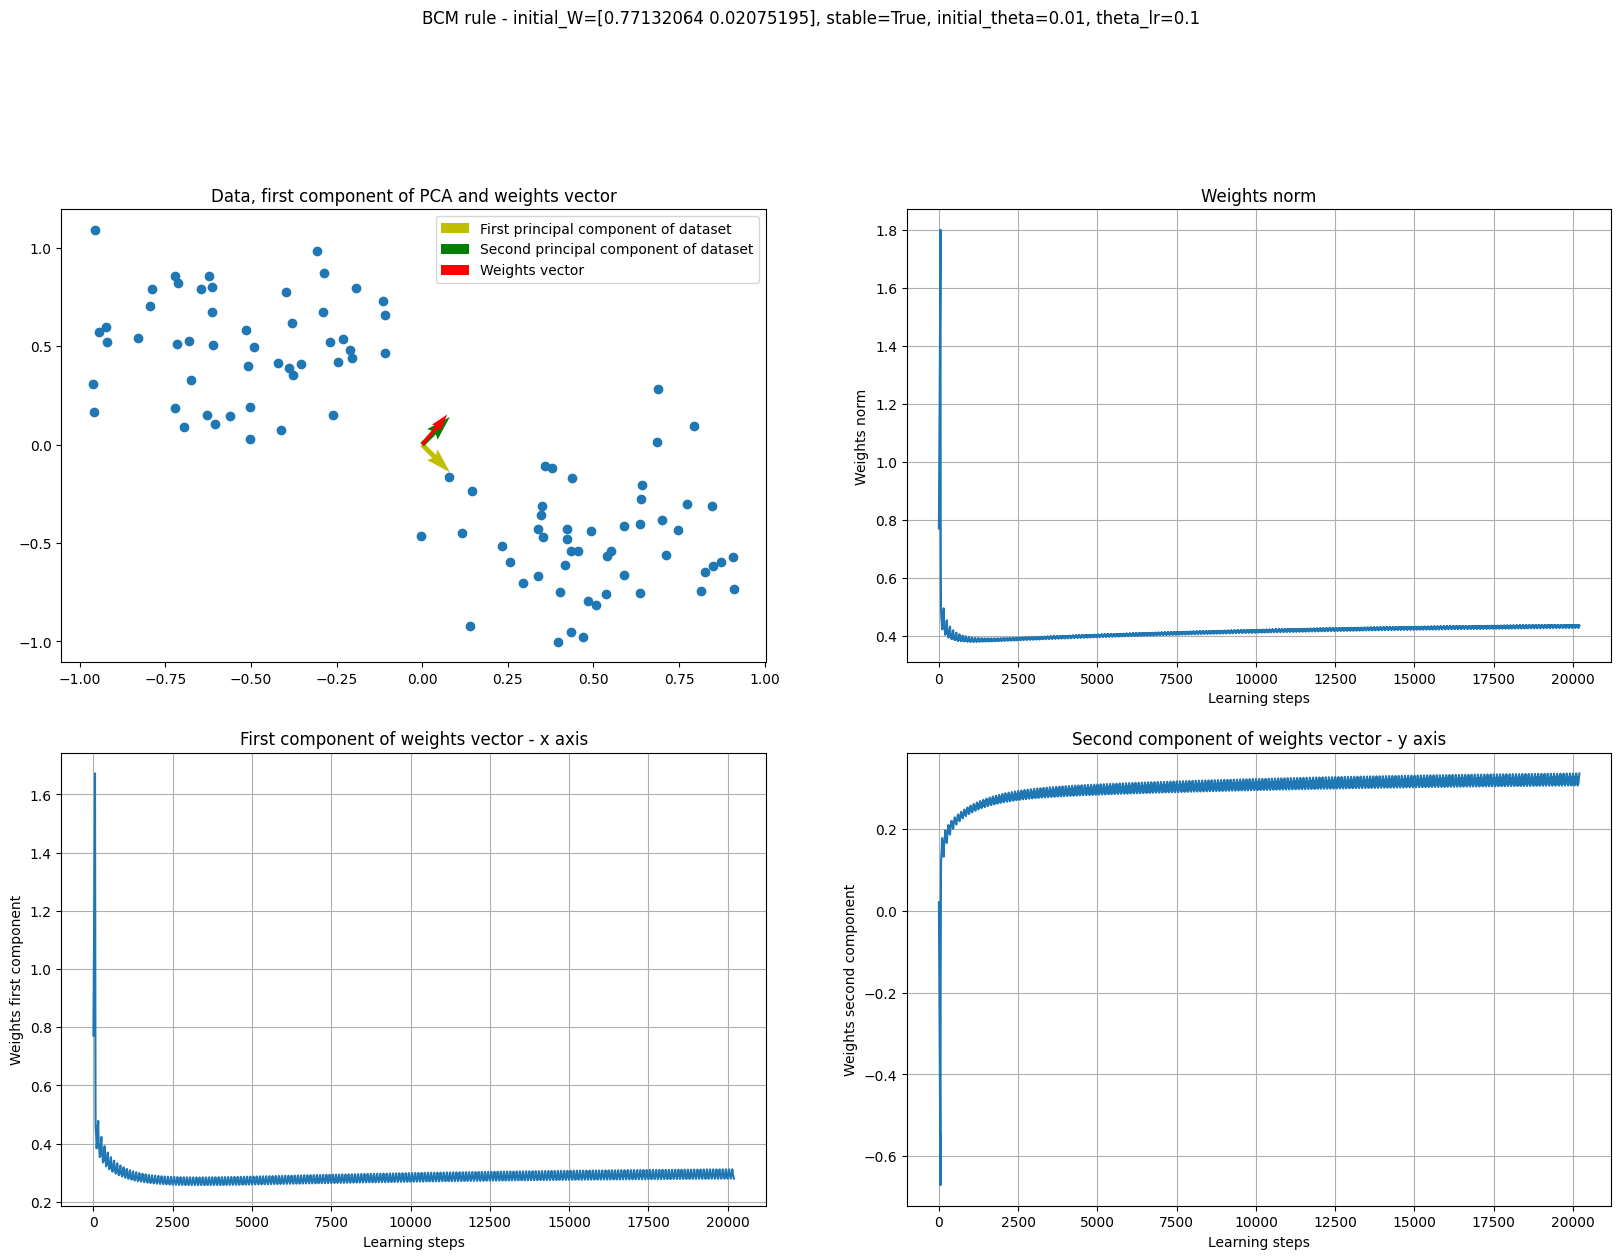

In [14]:
simulate_bcm_rule([
    (BCMRule(initial_theta=0.01, theta_lr=0.1), np.array([1, -0.8]), 100000, 0.1),
    (BCMRule(initial_theta=0.01, theta_lr=0.1), W, 10000, 0.1),
])

Here we try to change parameters of initial theta and theta learning rate of BCM rule. In both examples the first plot of data scatter plot the weights vector tends to be parallel to the second principal component.
1. In the first example we use higher hyperparameters and the convergence seem to be faster.
2. Here convergence seems to be slower.

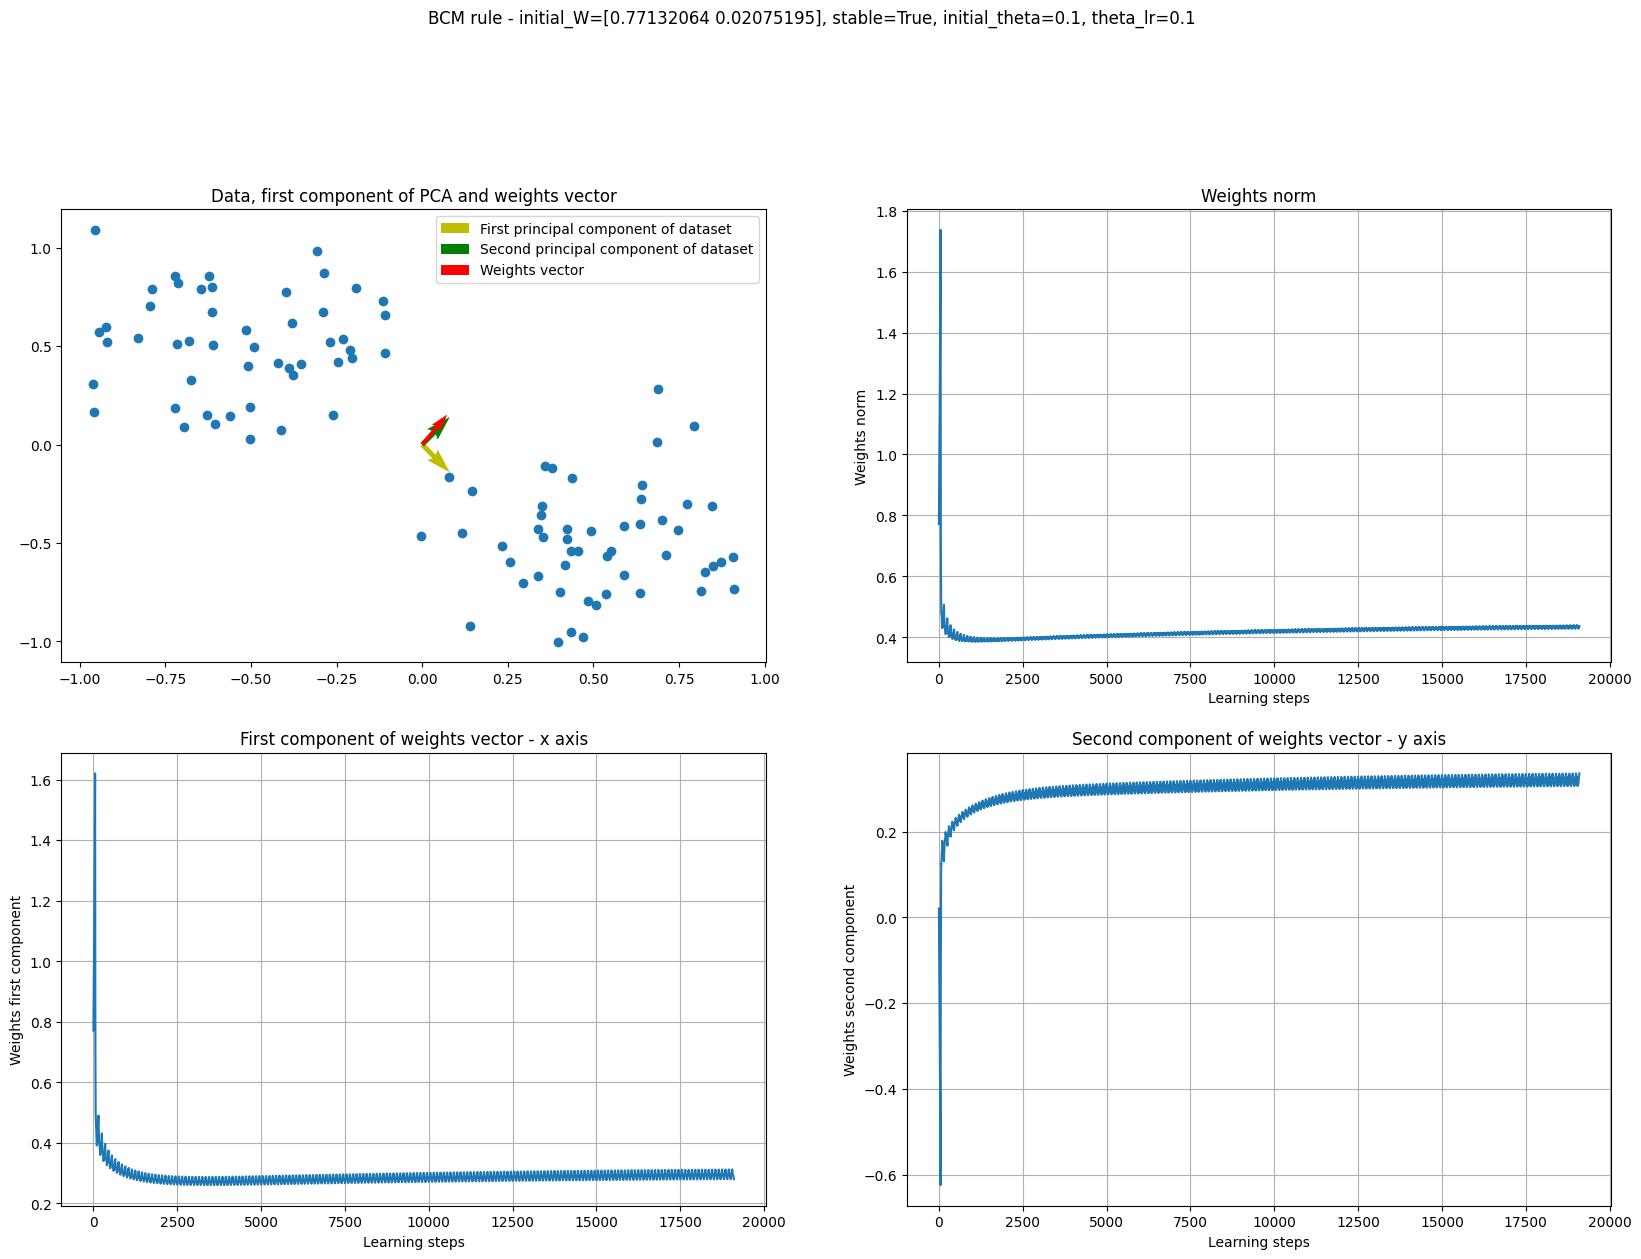

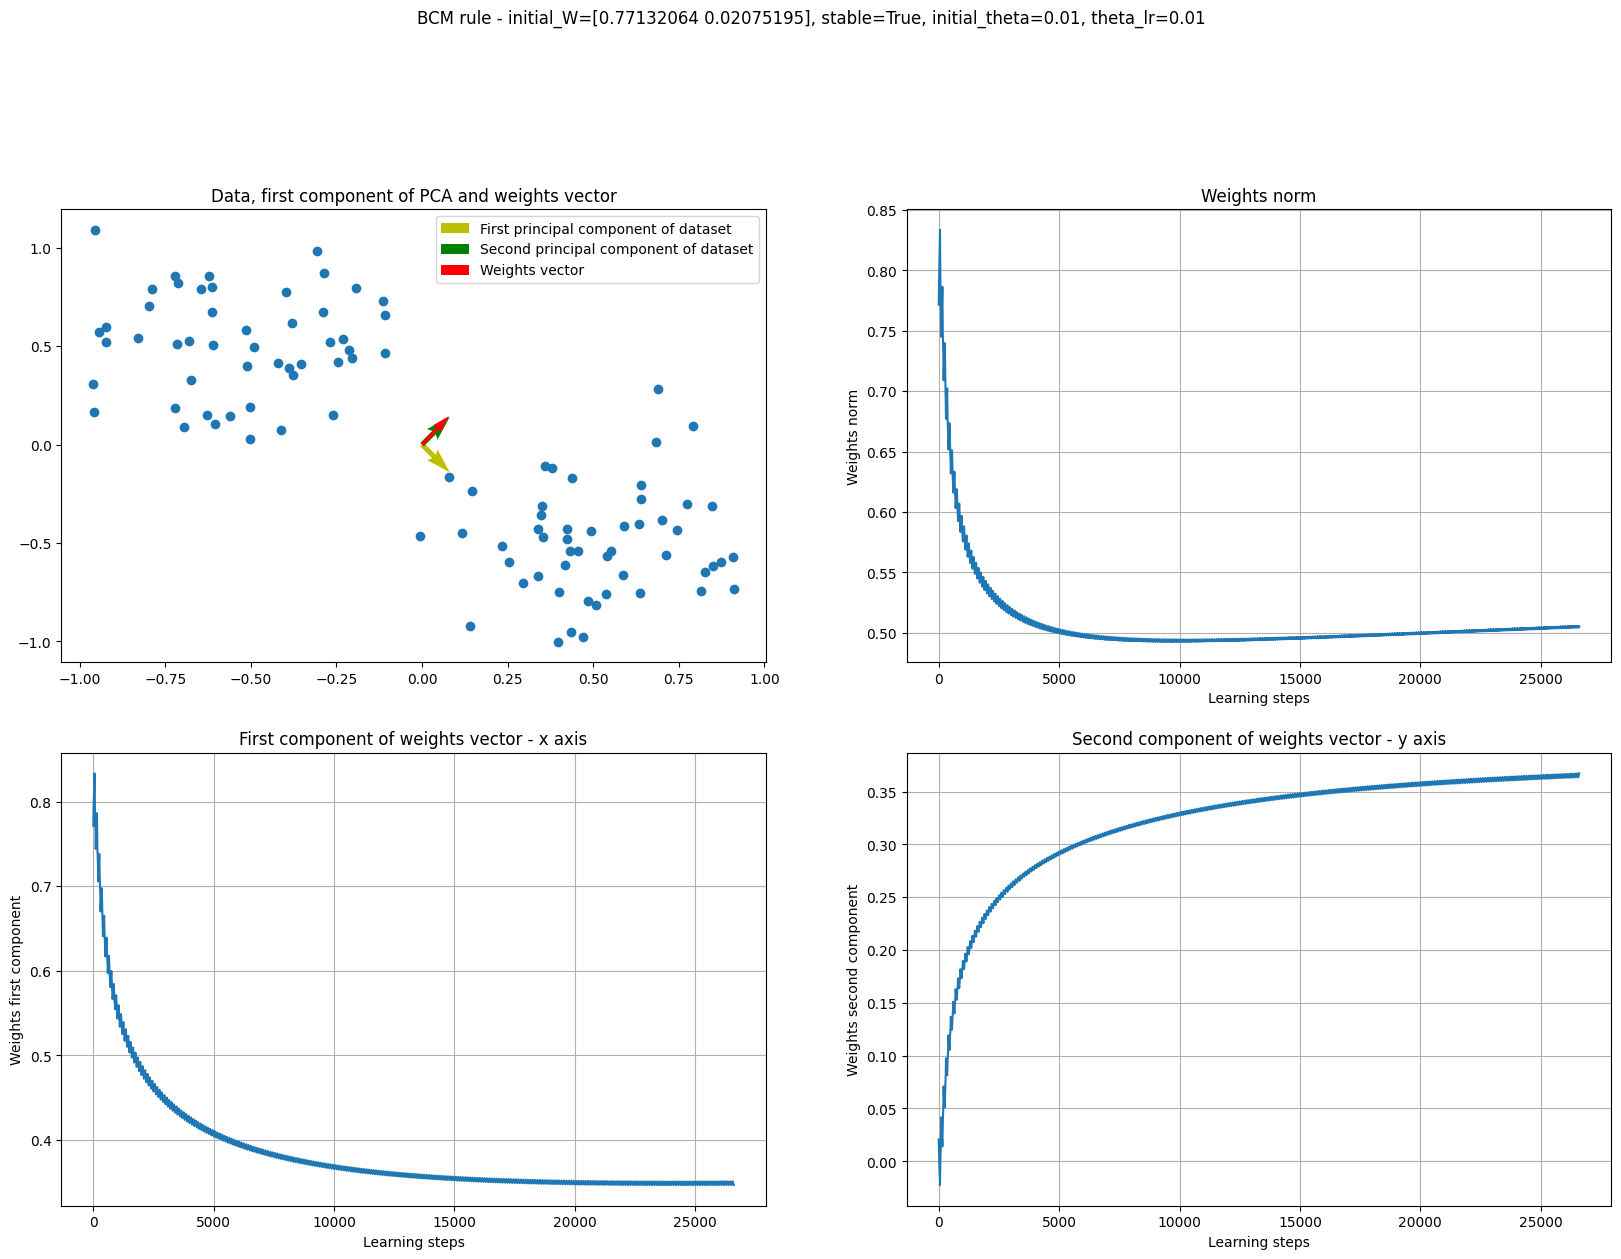

In [15]:
simulate_bcm_rule([
    (BCMRule(initial_theta=0.1, theta_lr=0.1), W, 10000, 0.1),
    (BCMRule(initial_theta=0.01, theta_lr=0.01), W, 10000, 0.01),
])

## Bonus track assignment 2 - Covariance rule

Class to handle theta value of covariance rule. This class implements the call method to use it as a function and pass it to the train function as a learning rule.

In [16]:
class CovarianceRule:
    """
    Class to handle theta value of covariance rule. This class implements the call method to use it as a function.
    """

    def __init__(self, initial_theta: float = 0.1) -> None:
        """
        Covariance rule class constructor.

        initial_theta: Initial vector of theta.
        """
        self.theta = initial_theta

    def __call__(self, v: float, u: np.array, w: np.array) -> np.array:
        """
        Function to make this class callable as a function.

        v: Postsynaptic firing rate value.
        u: Presynaptic firing rate vector.
        w: Weights vector.

        returns:
            np.array: Delta of weights passed to the train function to update the weights vector.
        """
        return v * (u - self.theta)

Function able to simulate the covariance rule with different configurations.

In [17]:
def simulate_covariance_rule(configs: list[tuple[CovarianceRule]]) -> None:
    """
    Function able to simulate the covariance rule with different configurations.

    configs: List of configurations.
    """
    for covariance_rule in configs:
        title = f'Covariance rule - initial_theta={covariance_rule.theta}'
        weights_over_time = train(data, W, learning_rule=covariance_rule, filename=title)
        plot_analysis(weights_over_time, title=title)

Simulations of covariance rule with different value of initial theta.
1. In the first example with a large value of theta the fist and second component of weights decrease over time. The growth (or degrowth) of first component, second component and norm of weights have a zig-zag behavior. The scatter plot of data shows that the weights vector is not aligned to first or second principal component vector.
2. In the second example with a smaller initial theta value the weights vector i more aligned to the first principal eigenvector and the first component of weights in the plot oscillates between positive and negative values.
3. In the third example with smaller value of theta first and second component of weights are in opposite direction (the first increase and the second decrease over time). The weights vector is more aligned to the first principal eigenvector.
4. In the forth example the weights vector is perfectly aligned to the first principal eigenvector. In term of first component, second component and norm of weights they follow the same direction of the previous example but with a smoother behavior (they seem to be less zig-zag).

In general the evolution of weights tends to a larger value i  first component, second component and norm of weights plot; so they seem to be unbounded for these values of theta.

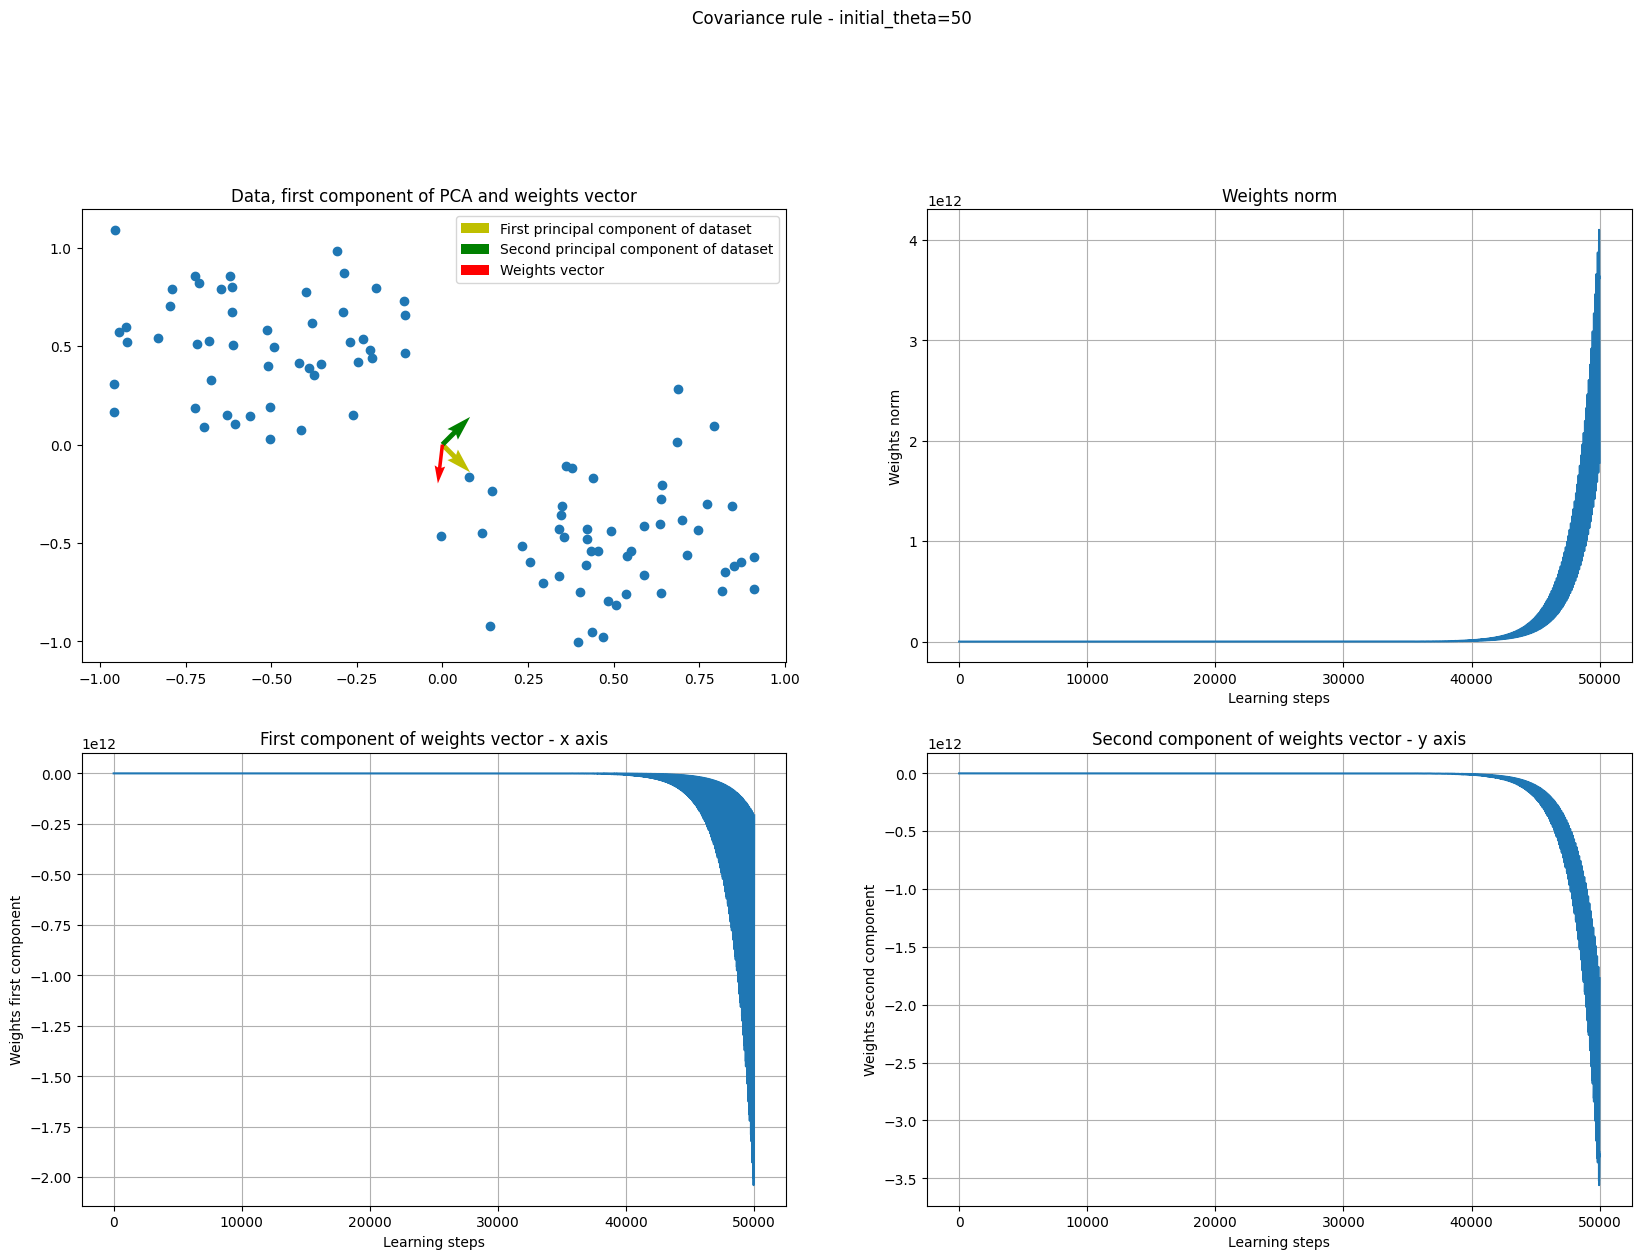

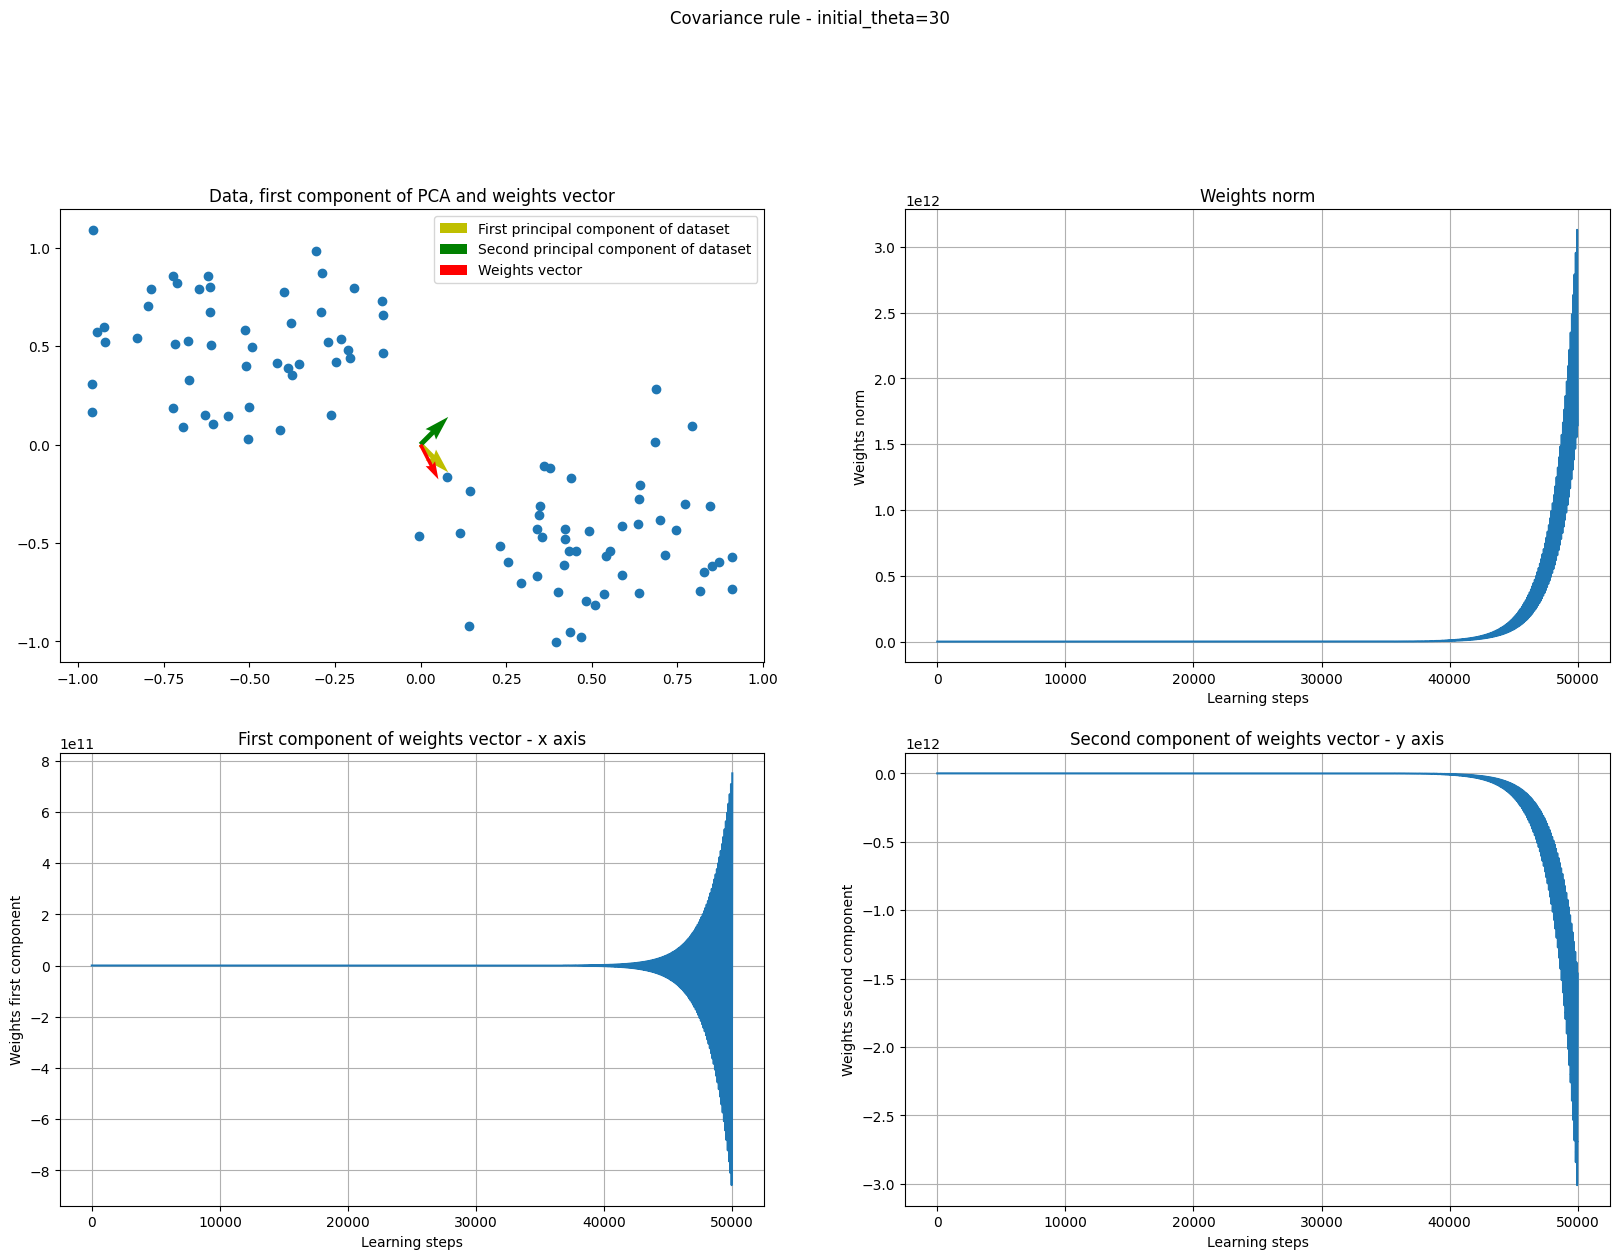

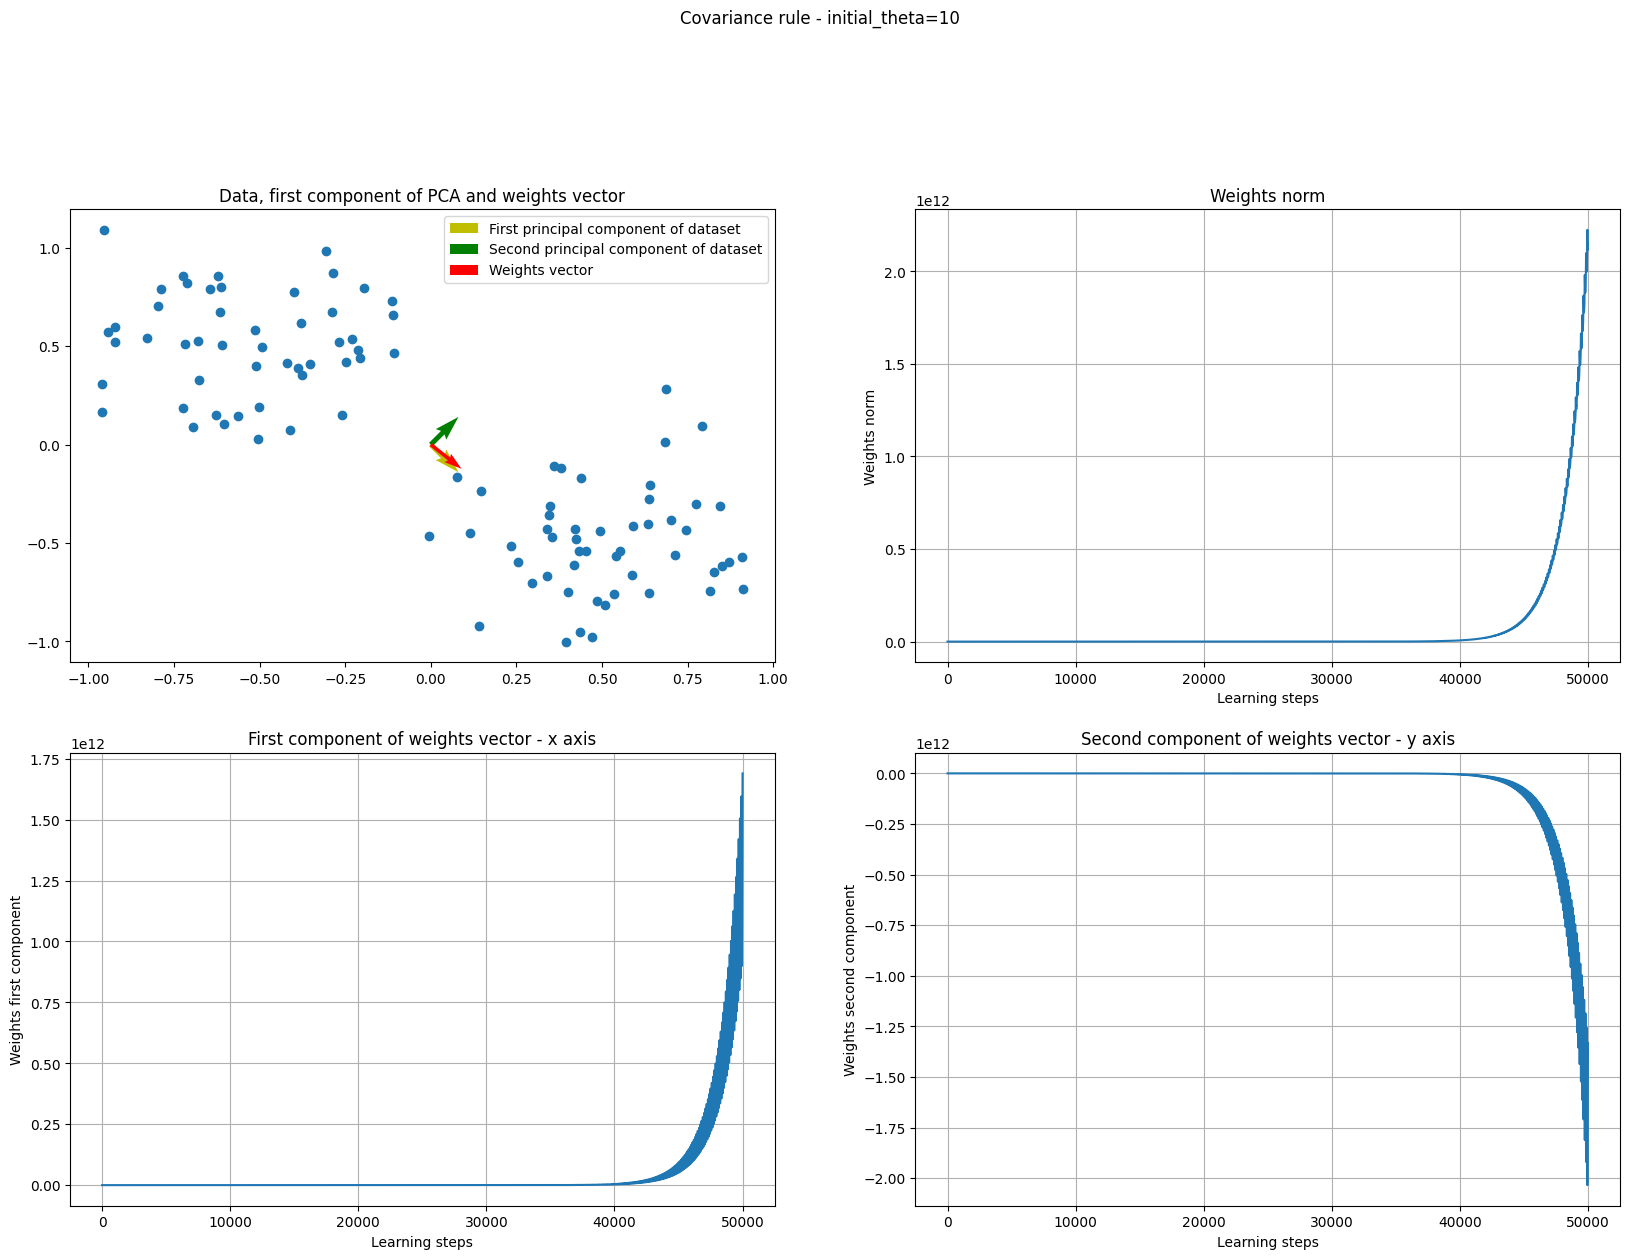

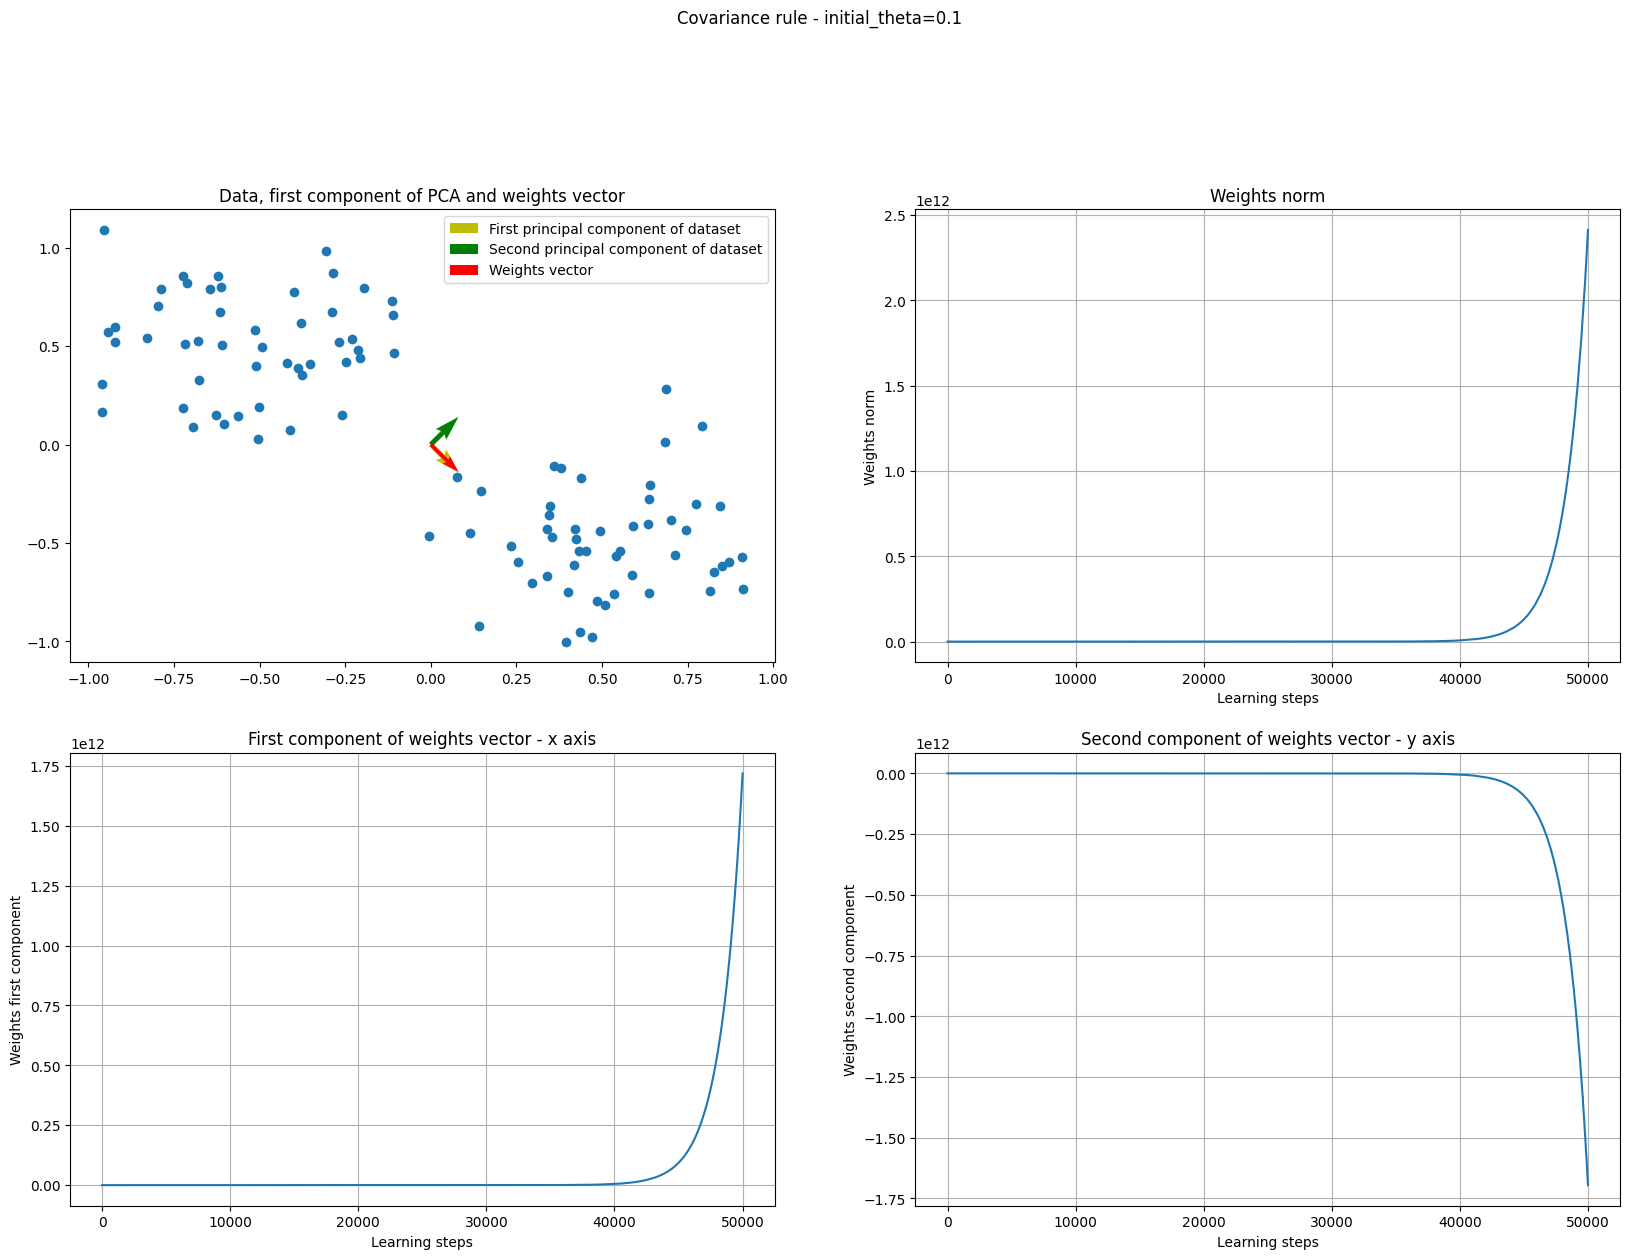

In [18]:
simulate_covariance_rule([
    CovarianceRule(initial_theta=50),
    CovarianceRule(initial_theta=30),
    CovarianceRule(initial_theta=10),
    CovarianceRule(initial_theta=0.1),
])

## Bonus track assignment 3 - Basic Hebbian rule and BCM rule with dataset2.

Loading of dataset2, principal components extraction and plot of dataset2 scatter plot with first and second principal eigenvectors and initial weights vector.

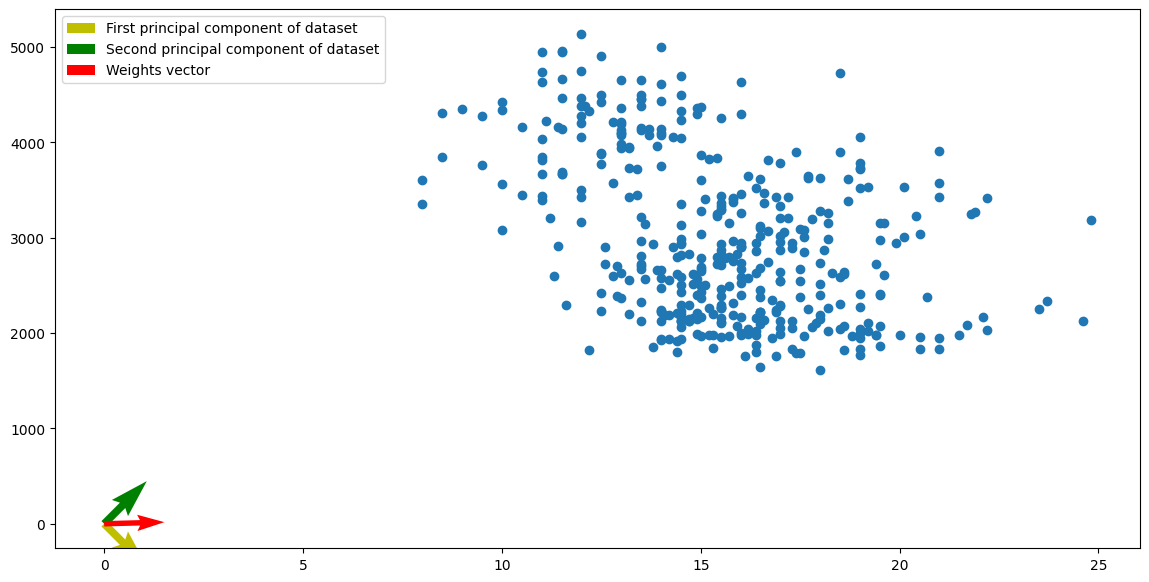

In [19]:
data2 = pd.read_csv('dataset2_lab_2_1.csv', header=None).to_numpy()
first_pc2, second_pc2 = extract_principal_components(data2)

plt.figure(figsize=(14, 7))
data_pc_w_plot(plt, data=data2, first_pc=first_pc2, second_pc=second_pc2, W=W)
plt.show()

Analysis of basic Hebbian rule applied to the dataset2. The weights vector is aligned to the first principal eigenvector. The first component and norm of weights seem to grow over time while second component of weights seem decrease over time. In general these last plot show us the unstable nature of the basic Hebbian rule.

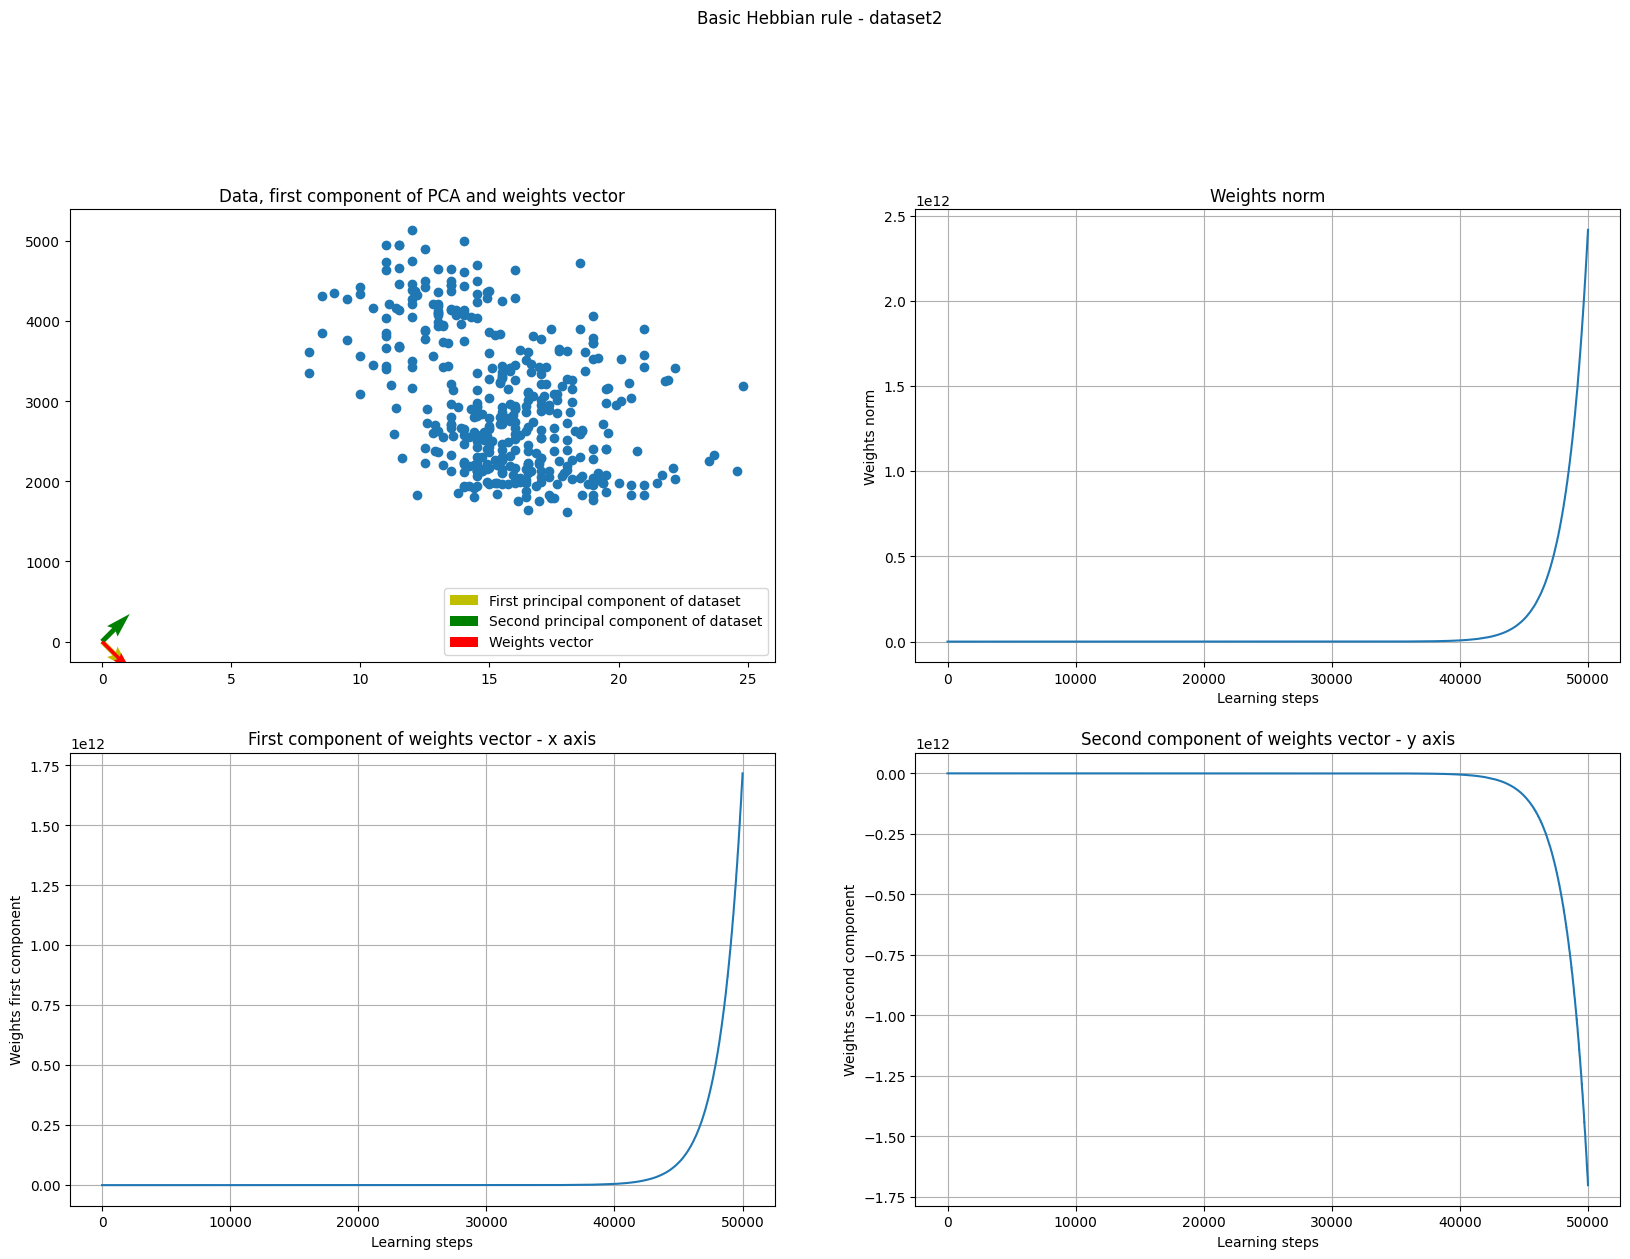

In [20]:
title = 'Basic Hebbian rule - dataset2'
basic_hebbian_rule = lambda v, u, w: v * u

weights_over_time = train(data2, W, learning_rule=basic_hebbian_rule, filename=title)
plot_analysis(weights_over_time, title=title, dataset=data2)

Analysis of BCM rule applied to dataset2 with different configurations.
1. In the first example is applied the unstable version of BCM rule that after some epochs stops because it's grown too much to handle numerical values reached.
2. In the second example we have a stable version of BCM rule where we can find that in scatter plot of data the weights vector is aligned to the second principal eigenvector. The first component, second component and norm of weights have a zig-zag behavior and seem to converge in a fixed interval.
3. In the third example we have the same of previous with an higher initial value of theta. In the scatter plot of data the weights vector is aligned to the second principal eigenvector. The first component, second component and norm of weights also have a zig-zag behavior less dense than before. As in the previous example these last plot seem to converge in a certain interval.

In the second and third example is clear that with stable BCM rule this learning rule is bounded.

/var/folders/mk/7s16j9k90j15d4m_gz0c5txc0000gn/T/ipykernel_18767/565437318.py:31: RuntimeWarning: overflow encountered in multiply
  return v * u * (v - self.theta)
/var/folders/mk/7s16j9k90j15d4m_gz0c5txc0000gn/T/ipykernel_18767/225604979.py:28: RuntimeWarning: invalid value encountered in add
  w = w + lr * delta_w
/Users/geremiapompei/Library/CloudStorage/OneDrive-UniversityofPisa/UNIPI/2_anno_2022_2023/2_semestre/computational neuroscience/assignments/cns_lab/venv/lib/python3.10/site-packages/matplotlib/quiver.py:628: RuntimeWarning: Mean of empty slice.
  amean = a[~self.Umask].mean()
/Users/geremiapompei/Library/CloudStorage/OneDrive-UniversityofPisa/UNIPI/2_anno_2022_2023/2_semestre/computational neuroscience/assignments/cns_lab/venv/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


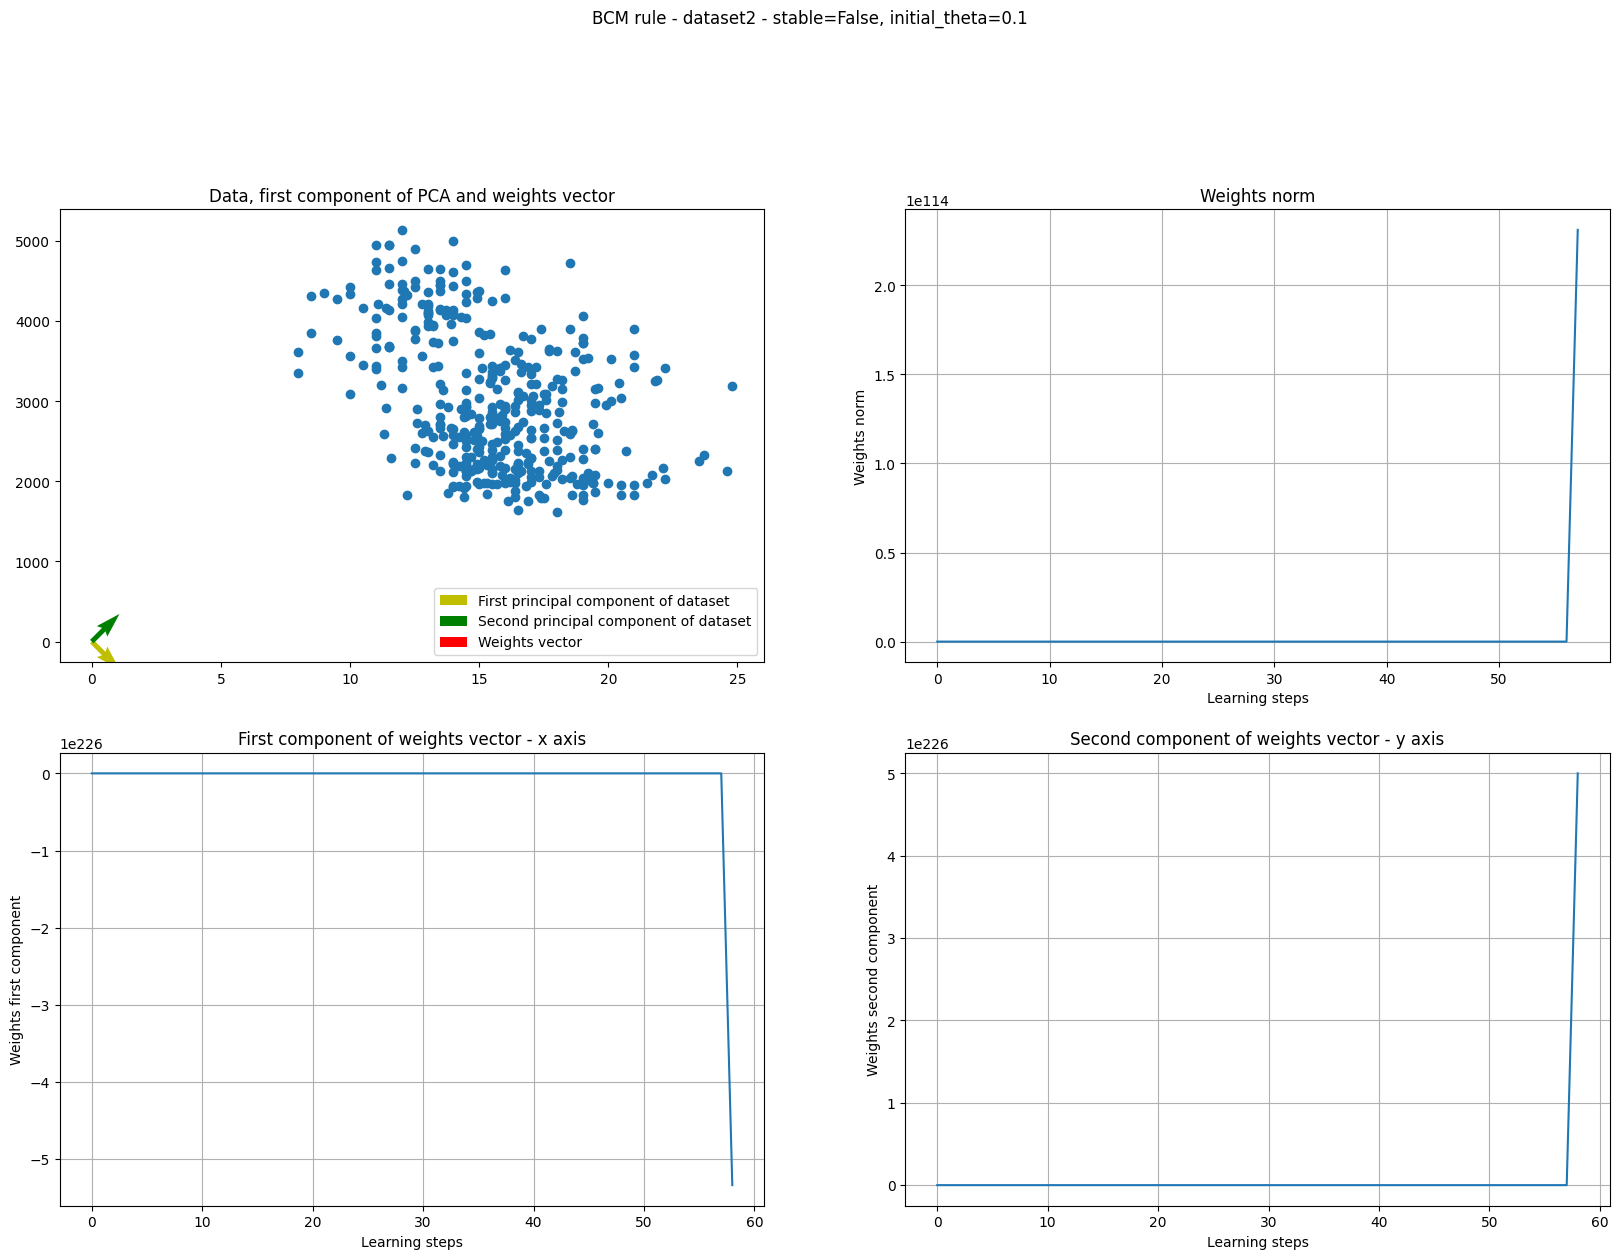

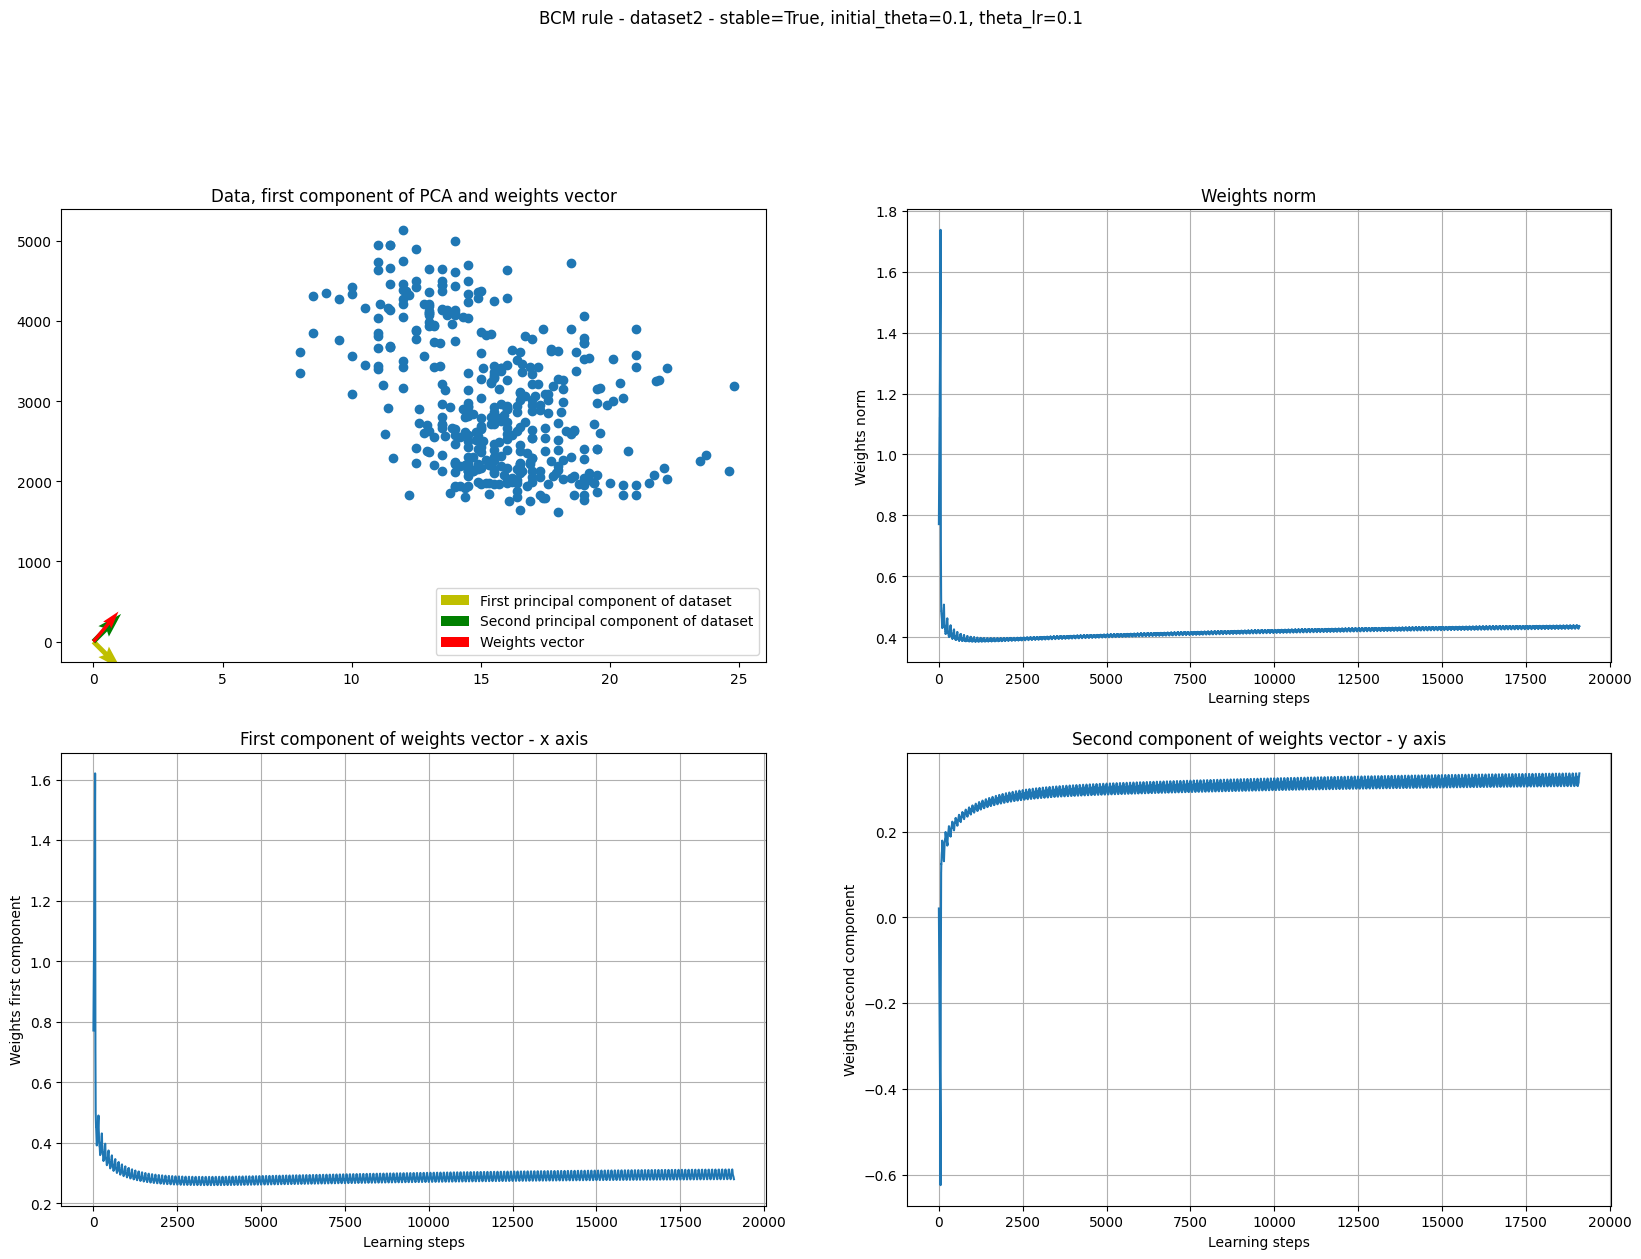

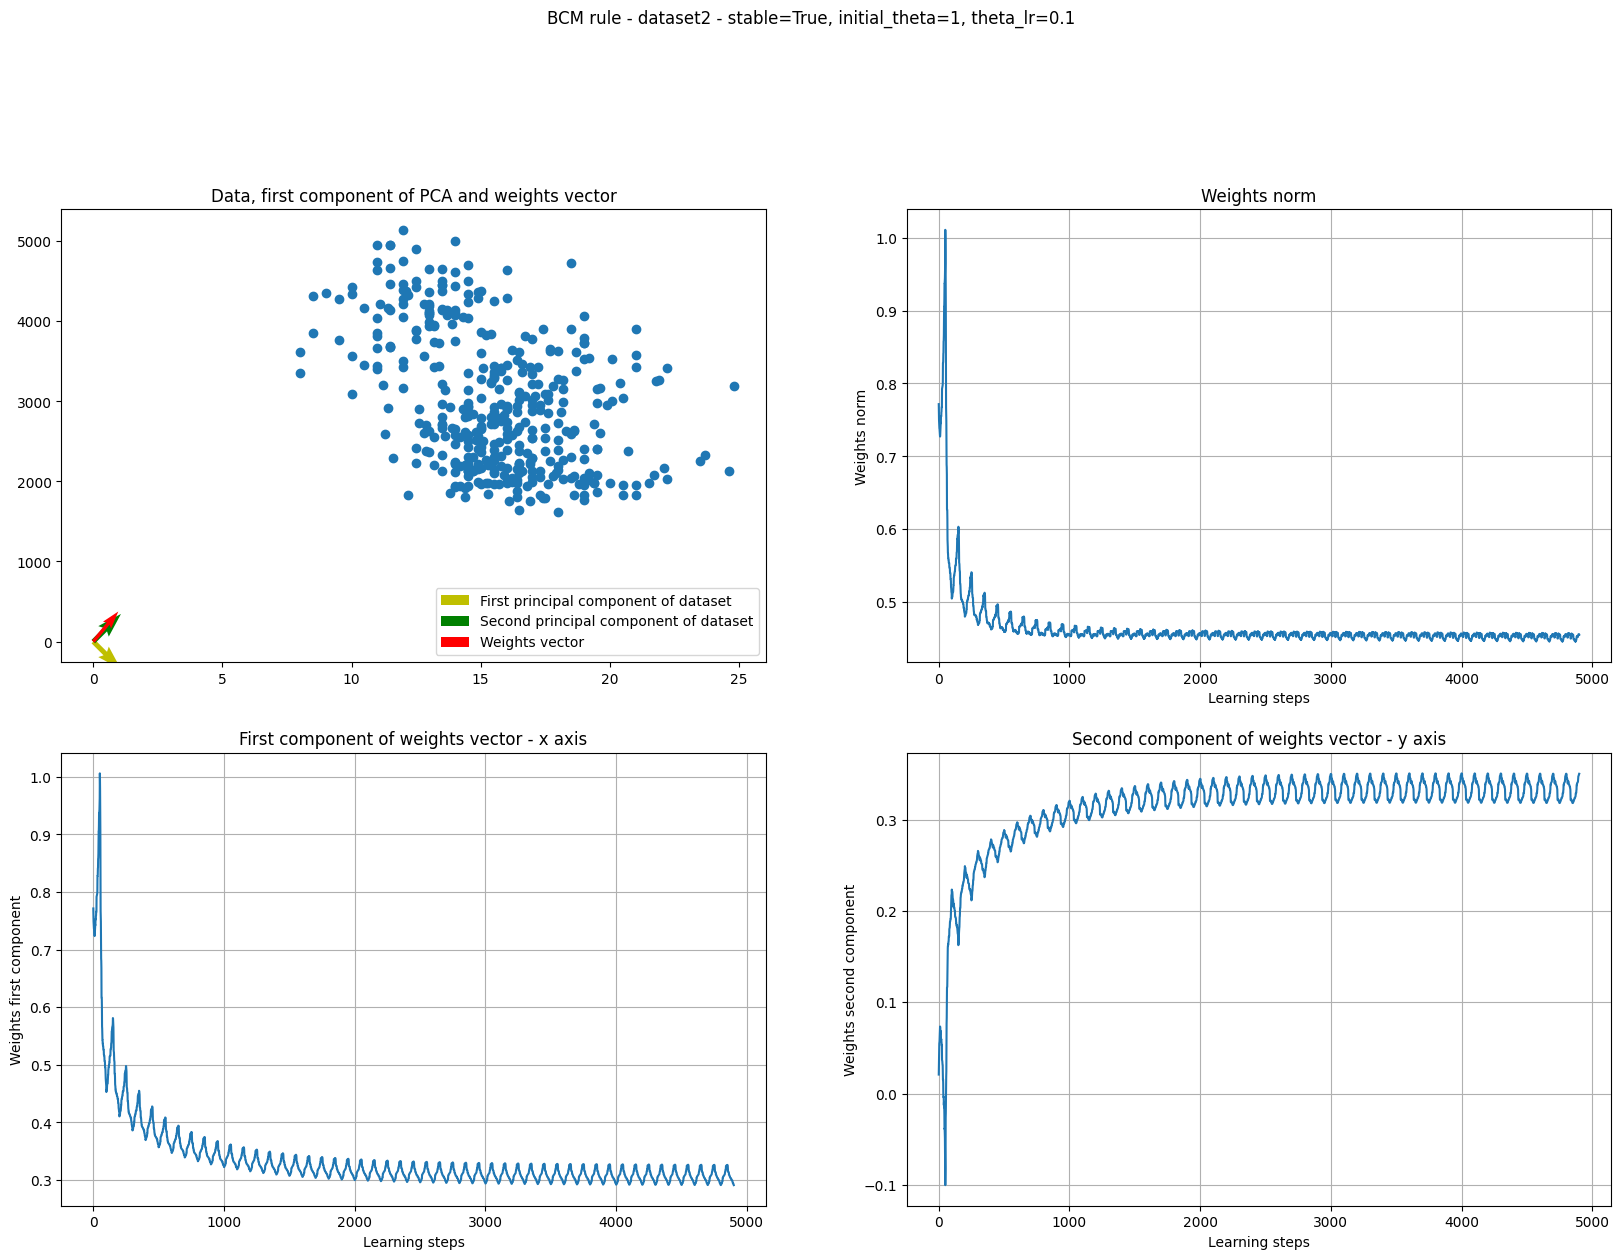

In [21]:
for bcm_rule in [
    BCMRule(initial_theta=0.1, stable=False),
    BCMRule(initial_theta=0.1, theta_lr=0.1),
    BCMRule(initial_theta=1, theta_lr=0.1),
]:
    title = f'BCM rule - dataset2 - stable={bcm_rule.stable}, initial_theta={bcm_rule.theta}'
    if bcm_rule.stable:
        title += f', theta_lr={bcm_rule.theta_lr}'
    weights_over_time = train(data2, W, learning_rule=bcm_rule, filename=title, epochs=10000, lr=0.1)
    plot_analysis(weights_over_time, title=title, dataset=data2)